In [1]:
! pip install -r requirements.txt

  Using cached torchsummary-1.5.1-py3-none-any.whl.metadata (296 bytes)
  Using cached scikit_learn-1.4.2-cp39-cp39-win_amd64.whl.metadata (11 kB)
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     -------------------- ----------------- 30.7/57.6 kB 660.6 kB/s eta 0:00:01
     -------------------------------------- 57.6/57.6 kB 763.1 kB/s eta 0:00:00
  Using cached pandas-2.2.2-cp39-cp39-win_amd64.whl.metadata (19 kB)
  Using cached matplotlib-3.8.4-cp39-cp39-win_amd64.whl.metadata (5.9 kB)
  Using cached ruamel.yaml-0.18.6-py3-none-any.whl.metadata (23 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached fsspec-2024.3.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached scipy-1.13.0-cp39-cp39-win_amd64.whl.metadata (60 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.2.1-cp39-cp39-win_amd64.whl.metadata (5.8 kB)
  Us

In [1]:
import torch 
torch.cuda.is_available()

True

In [3]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 4060 Laptop GPU'

In [4]:
ngpu= 1
# Decide which device we want to run on
#device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)



cuda:0


In [1]:
#! python main.py CNN
from __future__ import print_function
import os
import time
import json
import argparse


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve, f1_score,classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import models
from utils import Datasets
from utils.params import Params
from utils.plotting import plot_training
def main(modelName, batchSize):
    '''
    modelName: 'CNN', 'RESNET50',in hparams.yaml
    batchSize: loader size
    '''
    start_time = time.strftime("%d%m%y_%H%M%S")
    
    torch.cuda.empty_cache()
    params = Params("hparams.yaml", modelName)
    #os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
    #os.environ["CUDA_VISIBLE_DEVICES"]=params.gpu_vis_dev    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    
    # Load model that has been chosen via the command line arguments.
    model_module = __import__('.'.join(['models', params.model_name]),  fromlist=['object'])
    if params.model_name=='resnet50':
        model = model_module.net(model_module.Bottleneck, [3, 4, 6, 3], 10)

    else:
        model = model_module.net()
    

    # Send the model to the chosen device.
    # To use multiple GPUs
    #model = nn.DataParallel(model)
    model = model.to(device)
    #print('train X device:', model.device)
    
    #Grap your training and validation functions for your network.
    train = model_module.train
    val = model_module.val
    #test = model_module.test
    
    optimizer = optim.Adam(model.parameters(), lr=params.lr)
    
    if not os.path.exists(params.log_dir): os.makedirs(params.log_dir)
    if not os.path.exists(params.checkpoint_dir): os.makedirs(params.checkpoint_dir)
    if not os.path.exists("figs"): os.makedirs("figs")
    # Dataset root directory
    data_dir = './Data/images_original'
    # Define data preprocessing
    transform = transforms.Compose([
        #transforms.Resize((256, 256)),  
        #transforms.CenterCrop((334,216)),  
        transforms.ToTensor(),  #  Convert to tensor
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])
    if params.model_name=='resnet50' or params.model_name=='VGG16' :
        transform = transforms.Compose([
        transforms.Resize((256, 256)),  # 调整图像大小
        transforms.CenterCrop(224),  # 中心裁剪
        transforms.ToTensor(),  # 转换为张量
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
    ])
    
    #Data already splited
    train_dataset = torchvision.datasets.ImageFolder(root="Data/train", transform=transform)
    test_dataset = torchvision.datasets.ImageFolder(root="Data/test", transform=transform)        
    val_dataset = torchvision.datasets.ImageFolder(root="Data/valid", transform=transform)    
    
    # Create data loaders
    batch_size = batchSize
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    ##train
    val_accs = []
    val_losses = []
    train_losses = []
    train_accs = []
    

    # 记录训练开始时间
    start_time = time.time()
    
    #with torch.no_grad():
    for epoch in range(1, params.num_epochs + 1):
        torch.cuda.empty_cache()
        print("Epoch: {}".format(epoch))
        # Call training function.
        train(model, device, train_loader, optimizer)
        # Evaluate on both the training and validation set.
        train_loss, train_acc = val(model, device, train_loader)
        val_loss, val_acc = val(model, device, val_loader)
        # Collect some data for logging purposes.
        train_losses.append(float(train_loss))
        train_accs.append(train_acc)
        val_losses.append(float(val_loss))
        val_accs.append(val_acc)
    
        print('\n\ttrain Loss: {:.6f}\ttrain acc: {:.6f} \n\tval Loss: {:.6f}\tval acc: {:.6f}'.format(train_loss, train_acc, val_loss, val_acc))
    
        # Save model every few epochs (or even more often if you have the disk space).
        if epoch % 5 == 0:
            torch.save(model.state_dict(), os.path.join(params.checkpoint_dir,"checkpoint_{}_epoch_{}".format(modelName,epoch)))
    # 计算总的训练时间并打印
    total_time = time.time() - start_time
    print("Total training time: {:.2f} seconds.".format(total_time))
    # Clear plot each epoch
    fig = plot_training(train_losses, train_accs,val_losses, val_accs,modelName)
    fig.savefig(os.path.join("figs", "{}_training_vis".format(modelName)))

    # Some log information to help you keep track of your model information.
    logs ={
        "model": modelName,
        #"model": args.model_name,
        "train_losses": train_losses,
        "train_accs": train_accs,
        "val_losses": val_losses,
        "val_accs": val_accs,
        "best_val_epoch": int(np.argmax(val_accs)+1),
        #"model": args.model_name,
        "model": modelName,
        "lr": params.lr,
        "batch_size":params.batch_size
    }
    
    with open(os.path.join(params.log_dir,"{}_{}.json".format(modelName,  start_time)), 'w') as f:
        json.dump(logs, f)



cuda:0
Epoch: 1


100%|██████████| 20/20 [00:05<00:00,  4.21it/s]
20it [00:05,  3.71it/s]
100%|██████████| 20/20 [00:05<00:00,  3.71it/s]
C:\Users\Zoe\.conda\envs\precision-oncology\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,



	train Loss: 3.449673	train acc: 0.252855 
	val Loss: 2.414923	val acc: 0.208333
Epoch: 2


100%|██████████| 20/20 [00:03<00:00,  5.18it/s]
20it [00:03,  5.11it/s]
100%|██████████| 20/20 [00:03<00:00,  5.10it/s]



	train Loss: 2.547274	train acc: 0.280587 
	val Loss: 2.492305	val acc: 0.208333
Epoch: 3


100%|██████████| 20/20 [00:03<00:00,  4.98it/s]
20it [00:03,  5.03it/s]
100%|██████████| 20/20 [00:03<00:00,  5.02it/s]



	train Loss: 0.513951	train acc: 0.799347 
	val Loss: 1.445579	val acc: 0.486111
Epoch: 4


100%|██████████| 20/20 [00:03<00:00,  5.07it/s]
20it [00:03,  5.03it/s]
100%|██████████| 20/20 [00:03<00:00,  5.02it/s]



	train Loss: 0.277783	train acc: 0.900489 
	val Loss: 1.258578	val acc: 0.638889
Epoch: 5


100%|██████████| 20/20 [00:04<00:00,  4.89it/s]
20it [00:04,  4.92it/s]
100%|██████████| 20/20 [00:04<00:00,  4.92it/s]



	train Loss: 1.303388	train acc: 0.683524 
	val Loss: 2.362392	val acc: 0.611111
Epoch: 6


100%|██████████| 20/20 [00:04<00:00,  4.97it/s]
20it [00:04,  4.95it/s]
100%|██████████| 20/20 [00:04<00:00,  4.94it/s]



	train Loss: 0.084482	train acc: 0.965742 
	val Loss: 0.981612	val acc: 0.680556
Epoch: 7


100%|██████████| 20/20 [00:03<00:00,  5.10it/s]
20it [00:03,  5.04it/s]
100%|██████████| 20/20 [00:03<00:00,  5.03it/s]



	train Loss: 0.550288	train acc: 0.752039 
	val Loss: 2.118203	val acc: 0.347222
Epoch: 8


100%|██████████| 20/20 [00:03<00:00,  5.06it/s]
20it [00:03,  5.05it/s]
100%|██████████| 20/20 [00:03<00:00,  5.04it/s]



	train Loss: 0.746379	train acc: 0.810767 
	val Loss: 2.450269	val acc: 0.680556
Epoch: 9


100%|██████████| 20/20 [00:03<00:00,  5.11it/s]
20it [00:03,  5.02it/s]
100%|██████████| 20/20 [00:03<00:00,  5.01it/s]



	train Loss: 0.269626	train acc: 0.947798 
	val Loss: 0.936332	val acc: 0.694444
Epoch: 10


100%|██████████| 20/20 [00:03<00:00,  5.04it/s]
20it [00:03,  5.00it/s]
100%|██████████| 20/20 [00:04<00:00,  5.00it/s]



	train Loss: 0.329606	train acc: 0.872757 
	val Loss: 1.104657	val acc: 0.583333
Total training time: 86.74 seconds.


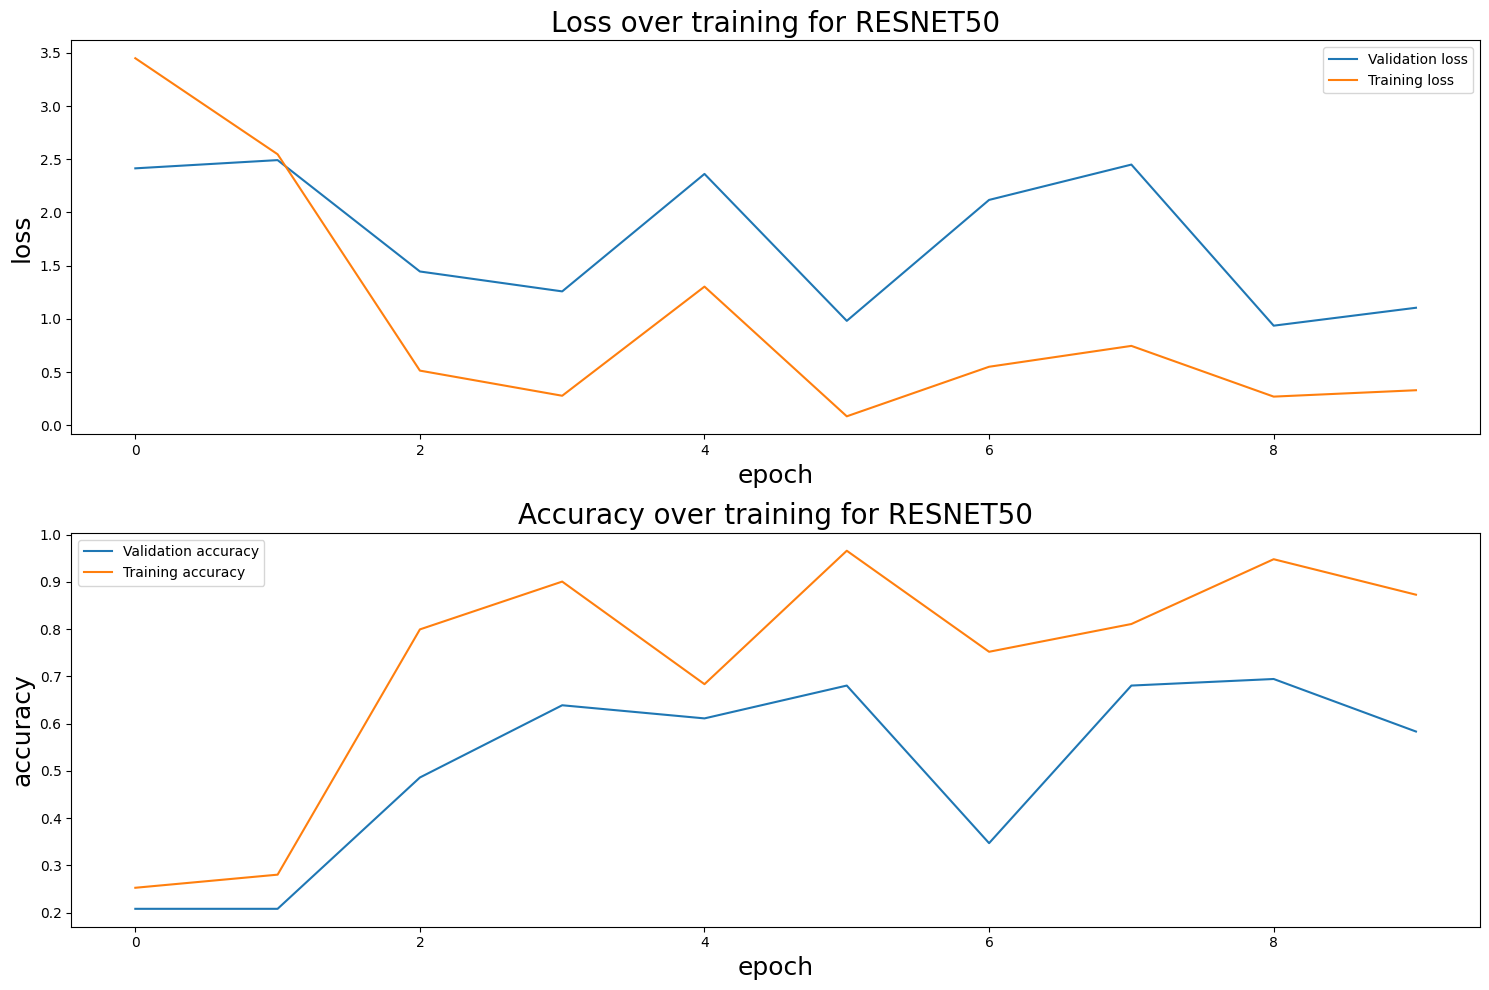

In [2]:
main("RESNET50",32)

cuda:0
Epoch: 1


100%|██████████| 20/20 [00:04<00:00,  5.18it/s]
20it [00:04,  4.67it/s]
100%|██████████| 20/20 [00:04<00:00,  4.66it/s]



	train Loss: 3.147861	train acc: 0.252855 
	val Loss: 2.237615	val acc: 0.208333
Epoch: 2


100%|██████████| 20/20 [00:03<00:00,  5.15it/s]
20it [00:03,  5.09it/s]
100%|██████████| 20/20 [00:03<00:00,  5.08it/s]



	train Loss: 1.843459	train acc: 0.355628 
	val Loss: 1.785041	val acc: 0.305556
Epoch: 3


100%|██████████| 20/20 [00:03<00:00,  5.16it/s]
20it [00:03,  5.08it/s]
100%|██████████| 20/20 [00:03<00:00,  5.08it/s]



	train Loss: 0.658296	train acc: 0.699837 
	val Loss: 0.942980	val acc: 0.486111
Epoch: 4


100%|██████████| 20/20 [00:03<00:00,  5.08it/s]
20it [00:03,  5.11it/s]
100%|██████████| 20/20 [00:03<00:00,  5.10it/s]



	train Loss: 0.422617	train acc: 0.843393 
	val Loss: 1.752135	val acc: 0.486111
Epoch: 5


100%|██████████| 20/20 [00:03<00:00,  5.10it/s]
20it [00:03,  5.05it/s]
100%|██████████| 20/20 [00:03<00:00,  5.04it/s]



	train Loss: 2.188527	train acc: 0.734095 
	val Loss: 1.209200	val acc: 0.625000
Epoch: 6


100%|██████████| 20/20 [00:03<00:00,  5.15it/s]
20it [00:03,  5.08it/s]
100%|██████████| 20/20 [00:03<00:00,  5.07it/s]



	train Loss: 0.636468	train acc: 0.831974 
	val Loss: 0.886800	val acc: 0.708333
Epoch: 7


100%|██████████| 20/20 [00:03<00:00,  5.06it/s]
20it [00:03,  5.01it/s]
100%|██████████| 20/20 [00:03<00:00,  5.00it/s]



	train Loss: 0.154338	train acc: 0.941272 
	val Loss: 1.445221	val acc: 0.597222
Epoch: 8


100%|██████████| 20/20 [00:03<00:00,  5.09it/s]
20it [00:03,  5.06it/s]
100%|██████████| 20/20 [00:03<00:00,  5.05it/s]



	train Loss: 0.410034	train acc: 0.805873 
	val Loss: 1.697993	val acc: 0.611111
Epoch: 9


100%|██████████| 20/20 [00:03<00:00,  5.12it/s]
20it [00:03,  5.02it/s]
100%|██████████| 20/20 [00:03<00:00,  5.01it/s]



	train Loss: 0.078391	train acc: 0.980424 
	val Loss: 1.125799	val acc: 0.541667
Epoch: 10


100%|██████████| 20/20 [00:03<00:00,  5.06it/s]
20it [00:03,  5.08it/s]
100%|██████████| 20/20 [00:03<00:00,  5.07it/s]



	train Loss: 0.036041	train acc: 0.988581 
	val Loss: 1.500875	val acc: 0.597222
Epoch: 11


100%|██████████| 20/20 [00:03<00:00,  5.07it/s]
20it [00:03,  5.06it/s]
100%|██████████| 20/20 [00:03<00:00,  5.05it/s]



	train Loss: 0.169690	train acc: 0.949429 
	val Loss: 1.180669	val acc: 0.597222
Epoch: 12


100%|██████████| 20/20 [00:03<00:00,  5.00it/s]
20it [00:03,  5.01it/s]
100%|██████████| 20/20 [00:04<00:00,  5.00it/s]



	train Loss: 0.068528	train acc: 0.980424 
	val Loss: 1.650264	val acc: 0.638889
Epoch: 13


100%|██████████| 20/20 [00:03<00:00,  4.99it/s]
20it [00:03,  5.03it/s]
100%|██████████| 20/20 [00:03<00:00,  5.02it/s]



	train Loss: 0.012243	train acc: 0.996737 
	val Loss: 1.025995	val acc: 0.625000
Epoch: 14


100%|██████████| 20/20 [00:03<00:00,  5.09it/s]
20it [00:03,  5.04it/s]
100%|██████████| 20/20 [00:03<00:00,  5.03it/s]



	train Loss: 0.007063	train acc: 0.998369 
	val Loss: 1.034113	val acc: 0.597222
Epoch: 15


100%|██████████| 20/20 [00:03<00:00,  5.06it/s]
20it [00:03,  5.05it/s]
100%|██████████| 20/20 [00:03<00:00,  5.04it/s]



	train Loss: 0.069909	train acc: 0.993475 
	val Loss: 1.472372	val acc: 0.638889
Epoch: 16


100%|██████████| 20/20 [00:04<00:00,  5.02it/s]
20it [00:04,  4.99it/s]
100%|██████████| 20/20 [00:04<00:00,  4.98it/s]



	train Loss: 0.235334	train acc: 0.910277 
	val Loss: 1.260760	val acc: 0.638889
Epoch: 17


100%|██████████| 20/20 [00:03<00:00,  5.03it/s]
20it [00:04,  5.00it/s]
100%|██████████| 20/20 [00:04<00:00,  4.99it/s]



	train Loss: 0.159681	train acc: 0.939641 
	val Loss: 1.735022	val acc: 0.597222
Epoch: 18


100%|██████████| 20/20 [00:03<00:00,  5.08it/s]
20it [00:04,  5.00it/s]
100%|██████████| 20/20 [00:04<00:00,  4.99it/s]



	train Loss: 0.179363	train acc: 0.951060 
	val Loss: 1.481060	val acc: 0.513889
Epoch: 19


100%|██████████| 20/20 [00:04<00:00,  4.95it/s]
20it [00:04,  4.96it/s]
100%|██████████| 20/20 [00:04<00:00,  4.95it/s]



	train Loss: 0.570215	train acc: 0.884176 
	val Loss: 1.676178	val acc: 0.569444
Epoch: 20


100%|██████████| 20/20 [00:03<00:00,  5.07it/s]
20it [00:03,  5.03it/s]
100%|██████████| 20/20 [00:03<00:00,  5.02it/s]



	train Loss: 0.141319	train acc: 0.964111 
	val Loss: 0.792037	val acc: 0.736111
Epoch: 21


100%|██████████| 20/20 [00:03<00:00,  5.11it/s]
20it [00:03,  5.05it/s]
100%|██████████| 20/20 [00:03<00:00,  5.04it/s]



	train Loss: 0.028571	train acc: 0.990212 
	val Loss: 0.911068	val acc: 0.694444
Epoch: 22


100%|██████████| 20/20 [00:03<00:00,  4.99it/s]
20it [00:03,  5.04it/s]
100%|██████████| 20/20 [00:03<00:00,  5.03it/s]



	train Loss: 0.028292	train acc: 0.995106 
	val Loss: 0.971947	val acc: 0.583333
Epoch: 23


100%|██████████| 20/20 [00:03<00:00,  5.10it/s]
20it [00:03,  5.00it/s]
100%|██████████| 20/20 [00:04<00:00,  5.00it/s]



	train Loss: 0.011052	train acc: 0.996737 
	val Loss: 0.804442	val acc: 0.680556
Epoch: 24


100%|██████████| 20/20 [00:03<00:00,  5.07it/s]
20it [00:03,  5.02it/s]
100%|██████████| 20/20 [00:03<00:00,  5.01it/s]



	train Loss: 0.013455	train acc: 0.996737 
	val Loss: 0.806384	val acc: 0.722222
Epoch: 25


100%|██████████| 20/20 [00:04<00:00,  5.02it/s]
20it [00:04,  4.92it/s]
100%|██████████| 20/20 [00:04<00:00,  4.92it/s]



	train Loss: 0.059737	train acc: 0.986949 
	val Loss: 1.346197	val acc: 0.611111
Epoch: 26


100%|██████████| 20/20 [00:04<00:00,  5.03it/s]
20it [00:04,  4.98it/s]
100%|██████████| 20/20 [00:04<00:00,  4.97it/s]



	train Loss: 0.011255	train acc: 0.996737 
	val Loss: 1.296404	val acc: 0.666667
Epoch: 27


100%|██████████| 20/20 [00:04<00:00,  5.08it/s]
20it [00:04,  5.00it/s]
100%|██████████| 20/20 [00:04<00:00,  5.00it/s]



	train Loss: 0.017668	train acc: 0.998369 
	val Loss: 1.009813	val acc: 0.625000
Epoch: 28


100%|██████████| 20/20 [00:04<00:00,  5.06it/s]
20it [00:04,  4.98it/s]
100%|██████████| 20/20 [00:04<00:00,  4.98it/s]



	train Loss: 0.058800	train acc: 0.983687 
	val Loss: 1.054040	val acc: 0.625000
Epoch: 29


100%|██████████| 20/20 [00:03<00:00,  5.04it/s]
20it [00:03,  5.00it/s]
100%|██████████| 20/20 [00:04<00:00,  5.00it/s]



	train Loss: 0.038039	train acc: 0.995106 
	val Loss: 0.934636	val acc: 0.694444
Epoch: 30


100%|██████████| 20/20 [00:03<00:00,  4.99it/s]
20it [00:03,  5.01it/s]
100%|██████████| 20/20 [00:03<00:00,  5.01it/s]



	train Loss: 0.019139	train acc: 0.996737 
	val Loss: 0.931618	val acc: 0.722222
Epoch: 31


100%|██████████| 20/20 [00:03<00:00,  5.00it/s]
20it [00:03,  5.01it/s]
100%|██████████| 20/20 [00:03<00:00,  5.00it/s]



	train Loss: 0.018432	train acc: 0.996737 
	val Loss: 0.941808	val acc: 0.736111
Epoch: 32


100%|██████████| 20/20 [00:04<00:00,  5.11it/s]
20it [00:04,  4.99it/s]
100%|██████████| 20/20 [00:04<00:00,  4.99it/s]



	train Loss: 0.009061	train acc: 0.996737 
	val Loss: 1.077577	val acc: 0.708333
Epoch: 33


100%|██████████| 20/20 [00:04<00:00,  5.08it/s]
20it [00:04,  4.98it/s]
100%|██████████| 20/20 [00:04<00:00,  4.97it/s]



	train Loss: 0.004525	train acc: 0.998369 
	val Loss: 0.851614	val acc: 0.763889
Epoch: 34


100%|██████████| 20/20 [00:03<00:00,  5.12it/s]
20it [00:03,  5.03it/s]
100%|██████████| 20/20 [00:03<00:00,  5.02it/s]



	train Loss: 0.003277	train acc: 0.998369 
	val Loss: 0.906442	val acc: 0.763889
Epoch: 35


100%|██████████| 20/20 [00:03<00:00,  5.10it/s]
20it [00:03,  5.04it/s]
100%|██████████| 20/20 [00:03<00:00,  5.03it/s]



	train Loss: 0.033609	train acc: 0.990212 
	val Loss: 1.002414	val acc: 0.694444
Epoch: 36


100%|██████████| 20/20 [00:03<00:00,  4.97it/s]
20it [00:03,  5.02it/s]
100%|██████████| 20/20 [00:03<00:00,  5.02it/s]



	train Loss: 0.008590	train acc: 0.996737 
	val Loss: 1.112843	val acc: 0.722222
Epoch: 37


100%|██████████| 20/20 [00:04<00:00,  5.03it/s]
20it [00:04,  4.97it/s]
100%|██████████| 20/20 [00:04<00:00,  4.96it/s]



	train Loss: 0.018964	train acc: 0.996737 
	val Loss: 1.449030	val acc: 0.625000
Epoch: 38


100%|██████████| 20/20 [00:04<00:00,  5.10it/s]
20it [00:03,  5.00it/s]
100%|██████████| 20/20 [00:04<00:00,  4.99it/s]



	train Loss: 0.006813	train acc: 0.998369 
	val Loss: 1.533705	val acc: 0.708333
Epoch: 39


100%|██████████| 20/20 [00:04<00:00,  5.01it/s]
20it [00:04,  4.99it/s]
100%|██████████| 20/20 [00:04<00:00,  4.99it/s]



	train Loss: 0.033856	train acc: 0.991843 
	val Loss: 1.760902	val acc: 0.694444
Epoch: 40


100%|██████████| 20/20 [00:03<00:00,  4.99it/s]
20it [00:03,  5.02it/s]
100%|██████████| 20/20 [00:03<00:00,  5.01it/s]



	train Loss: 0.019811	train acc: 0.995106 
	val Loss: 1.494253	val acc: 0.569444
Epoch: 41


100%|██████████| 20/20 [00:04<00:00,  5.07it/s]
20it [00:04,  5.00it/s]
100%|██████████| 20/20 [00:04<00:00,  4.99it/s]



	train Loss: 0.008209	train acc: 0.996737 
	val Loss: 1.373770	val acc: 0.625000
Epoch: 42


100%|██████████| 20/20 [00:04<00:00,  5.00it/s]
20it [00:04,  4.97it/s]
100%|██████████| 20/20 [00:04<00:00,  4.96it/s]



	train Loss: 0.004481	train acc: 0.998369 
	val Loss: 1.131683	val acc: 0.638889
Epoch: 43


100%|██████████| 20/20 [00:04<00:00,  5.07it/s]
20it [00:04,  4.96it/s]
100%|██████████| 20/20 [00:04<00:00,  4.96it/s]



	train Loss: 0.006407	train acc: 0.998369 
	val Loss: 1.273982	val acc: 0.652778
Epoch: 44


100%|██████████| 20/20 [00:04<00:00,  4.92it/s]
20it [00:04,  4.97it/s]
100%|██████████| 20/20 [00:04<00:00,  4.96it/s]



	train Loss: 0.019482	train acc: 0.993475 
	val Loss: 1.230672	val acc: 0.625000
Epoch: 45


100%|██████████| 20/20 [00:04<00:00,  5.00it/s]
20it [00:04,  4.98it/s]
100%|██████████| 20/20 [00:04<00:00,  4.97it/s]



	train Loss: 0.027839	train acc: 0.990212 
	val Loss: 0.934642	val acc: 0.708333
Epoch: 46


100%|██████████| 20/20 [00:04<00:00,  5.06it/s]
20it [00:04,  4.97it/s]
100%|██████████| 20/20 [00:04<00:00,  4.96it/s]



	train Loss: 0.075916	train acc: 0.982055 
	val Loss: 1.868634	val acc: 0.569444
Epoch: 47


100%|██████████| 20/20 [00:03<00:00,  5.04it/s]
20it [00:03,  5.01it/s]
100%|██████████| 20/20 [00:04<00:00,  5.00it/s]



	train Loss: 0.029633	train acc: 0.983687 
	val Loss: 1.111667	val acc: 0.694444
Epoch: 48


100%|██████████| 20/20 [00:03<00:00,  5.06it/s]
20it [00:04,  5.00it/s]
100%|██████████| 20/20 [00:04<00:00,  4.99it/s]



	train Loss: 0.007669	train acc: 0.996737 
	val Loss: 1.026355	val acc: 0.694444
Epoch: 49


100%|██████████| 20/20 [00:04<00:00,  5.11it/s]
20it [00:04,  4.98it/s]
100%|██████████| 20/20 [00:04<00:00,  4.98it/s]



	train Loss: 0.005189	train acc: 0.998369 
	val Loss: 1.338357	val acc: 0.611111
Epoch: 50


100%|██████████| 20/20 [00:04<00:00,  5.05it/s]
20it [00:04,  4.96it/s]
100%|██████████| 20/20 [00:04<00:00,  4.95it/s]



	train Loss: 0.006641	train acc: 0.998369 
	val Loss: 2.200917	val acc: 0.625000


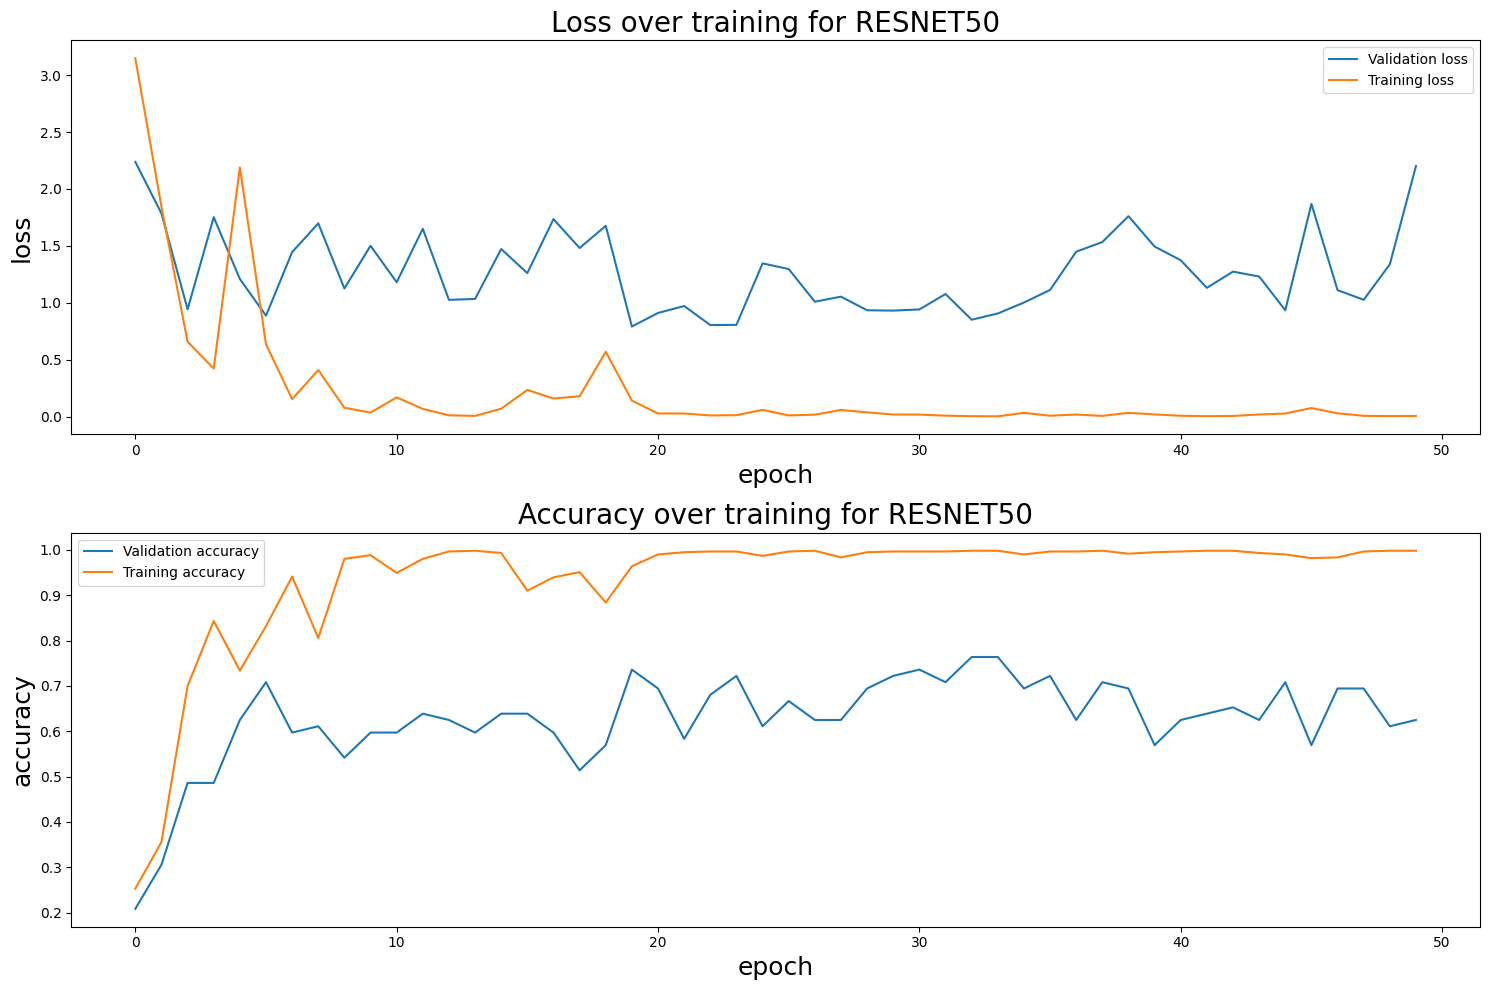

In [8]:
# more epoches:50
main("RESNET50",32)

cuda:0
Epoch: 1


100%|██████████| 10/10 [00:04<00:00,  2.23it/s]
10it [00:04,  2.17it/s]
100%|██████████| 10/10 [00:04<00:00,  2.16it/s]
C:\Users\Zoe\.conda\envs\precision-oncology\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,



	train Loss: 2.198555	train acc: 0.252855 
	val Loss: 1.472271	val acc: 0.208333
Epoch: 2


100%|██████████| 10/10 [00:03<00:00,  2.56it/s]
10it [00:03,  2.61it/s]
100%|██████████| 10/10 [00:03<00:00,  2.61it/s]



	train Loss: 3.539653	train acc: 0.252855 
	val Loss: 1.944811	val acc: 0.208333
Epoch: 3


100%|██████████| 10/10 [00:03<00:00,  2.56it/s]
10it [00:03,  2.62it/s]
100%|██████████| 10/10 [00:03<00:00,  2.62it/s]



	train Loss: 5.982900	train acc: 0.252855 
	val Loss: 3.573205	val acc: 0.208333
Epoch: 4


100%|██████████| 10/10 [00:03<00:00,  2.55it/s]
10it [00:03,  2.62it/s]
100%|██████████| 10/10 [00:03<00:00,  2.62it/s]



	train Loss: 4.972228	train acc: 0.275693 
	val Loss: 3.562911	val acc: 0.208333
Epoch: 5


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]
10it [00:03,  2.60it/s]
100%|██████████| 10/10 [00:03<00:00,  2.59it/s]



	train Loss: 3.249759	train acc: 0.274062 
	val Loss: 3.318187	val acc: 0.208333
Epoch: 6


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]
10it [00:03,  2.60it/s]
100%|██████████| 10/10 [00:03<00:00,  2.60it/s]



	train Loss: 0.246270	train acc: 0.887439 
	val Loss: 1.264910	val acc: 0.541667
Epoch: 7


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]
10it [00:03,  2.60it/s]
100%|██████████| 10/10 [00:03<00:00,  2.59it/s]



	train Loss: 0.345884	train acc: 0.884176 
	val Loss: 3.015835	val acc: 0.625000
Epoch: 8


100%|██████████| 10/10 [00:03<00:00,  2.55it/s]
10it [00:03,  2.55it/s]
100%|██████████| 10/10 [00:03<00:00,  2.55it/s]



	train Loss: 0.687667	train acc: 0.827080 
	val Loss: 2.562213	val acc: 0.527778
Epoch: 9


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
10it [00:03,  2.59it/s]
100%|██████████| 10/10 [00:03<00:00,  2.59it/s]



	train Loss: 0.098565	train acc: 0.962480 
	val Loss: 2.415060	val acc: 0.513889
Epoch: 10


100%|██████████| 10/10 [00:03<00:00,  2.55it/s]
10it [00:03,  2.60it/s]
100%|██████████| 10/10 [00:03<00:00,  2.60it/s]



	train Loss: 0.736100	train acc: 0.791191 
	val Loss: 2.397044	val acc: 0.638889
Epoch: 11


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
10it [00:03,  2.58it/s]
100%|██████████| 10/10 [00:03<00:00,  2.58it/s]



	train Loss: 0.135725	train acc: 0.934747 
	val Loss: 2.109845	val acc: 0.583333
Epoch: 12


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
10it [00:03,  2.57it/s]
100%|██████████| 10/10 [00:03<00:00,  2.56it/s]



	train Loss: 0.022981	train acc: 0.996737 
	val Loss: 1.771580	val acc: 0.666667
Epoch: 13


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
10it [00:03,  2.60it/s]
100%|██████████| 10/10 [00:03<00:00,  2.60it/s]



	train Loss: 0.017450	train acc: 0.993475 
	val Loss: 1.394673	val acc: 0.638889
Epoch: 14


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
10it [00:03,  2.57it/s]
100%|██████████| 10/10 [00:03<00:00,  2.57it/s]



	train Loss: 0.006873	train acc: 0.998369 
	val Loss: 1.205505	val acc: 0.736111
Epoch: 15


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]
10it [00:03,  2.58it/s]
100%|██████████| 10/10 [00:03<00:00,  2.58it/s]



	train Loss: 0.009038	train acc: 0.998369 
	val Loss: 1.327267	val acc: 0.722222
Epoch: 16


100%|██████████| 10/10 [00:03<00:00,  2.55it/s]
10it [00:03,  2.55it/s]
100%|██████████| 10/10 [00:03<00:00,  2.55it/s]



	train Loss: 0.025017	train acc: 0.991843 
	val Loss: 1.267255	val acc: 0.638889
Epoch: 17


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]
10it [00:03,  2.59it/s]
100%|██████████| 10/10 [00:03<00:00,  2.58it/s]



	train Loss: 0.017069	train acc: 0.993475 
	val Loss: 0.867647	val acc: 0.722222
Epoch: 18


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
10it [00:03,  2.58it/s]
100%|██████████| 10/10 [00:03<00:00,  2.57it/s]



	train Loss: 0.005926	train acc: 0.998369 
	val Loss: 0.997563	val acc: 0.666667
Epoch: 19


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]
10it [00:03,  2.59it/s]
100%|██████████| 10/10 [00:03<00:00,  2.58it/s]



	train Loss: 0.004095	train acc: 0.998369 
	val Loss: 1.356184	val acc: 0.666667
Epoch: 20


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]
10it [00:03,  2.58it/s]
100%|██████████| 10/10 [00:03<00:00,  2.58it/s]



	train Loss: 0.146764	train acc: 0.951060 
	val Loss: 1.564089	val acc: 0.708333
Epoch: 21


100%|██████████| 10/10 [00:03<00:00,  2.52it/s]
10it [00:03,  2.57it/s]
100%|██████████| 10/10 [00:03<00:00,  2.57it/s]



	train Loss: 0.022553	train acc: 0.991843 
	val Loss: 1.237261	val acc: 0.680556
Epoch: 22


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
10it [00:03,  2.57it/s]
100%|██████████| 10/10 [00:03<00:00,  2.57it/s]



	train Loss: 0.021941	train acc: 0.991843 
	val Loss: 1.337551	val acc: 0.708333
Epoch: 23


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]
10it [00:03,  2.59it/s]
100%|██████████| 10/10 [00:03<00:00,  2.59it/s]



	train Loss: 0.011408	train acc: 0.995106 
	val Loss: 1.885048	val acc: 0.666667
Epoch: 24


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
10it [00:03,  2.58it/s]
100%|██████████| 10/10 [00:03<00:00,  2.58it/s]



	train Loss: 0.028120	train acc: 0.991843 
	val Loss: 1.811325	val acc: 0.652778
Epoch: 25


100%|██████████| 10/10 [00:03<00:00,  2.52it/s]
10it [00:03,  2.58it/s]
100%|██████████| 10/10 [00:03<00:00,  2.58it/s]



	train Loss: 0.006562	train acc: 0.996737 
	val Loss: 1.573234	val acc: 0.638889
Epoch: 26


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]
10it [00:03,  2.61it/s]
100%|██████████| 10/10 [00:03<00:00,  2.60it/s]



	train Loss: 0.006069	train acc: 0.998369 
	val Loss: 2.095876	val acc: 0.694444
Epoch: 27


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
10it [00:03,  2.57it/s]
100%|██████████| 10/10 [00:03<00:00,  2.57it/s]



	train Loss: 0.003650	train acc: 0.998369 
	val Loss: 1.624383	val acc: 0.722222
Epoch: 28


100%|██████████| 10/10 [00:03<00:00,  2.52it/s]
10it [00:03,  2.55it/s]
100%|██████████| 10/10 [00:03<00:00,  2.55it/s]



	train Loss: 0.002992	train acc: 0.998369 
	val Loss: 1.357153	val acc: 0.750000
Epoch: 29


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]
10it [00:03,  2.61it/s]
100%|██████████| 10/10 [00:03<00:00,  2.61it/s]



	train Loss: 0.002690	train acc: 0.998369 
	val Loss: 1.158703	val acc: 0.680556
Epoch: 30


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]
10it [00:03,  2.58it/s]
100%|██████████| 10/10 [00:03<00:00,  2.58it/s]



	train Loss: 0.003336	train acc: 0.998369 
	val Loss: 1.149181	val acc: 0.708333
Epoch: 31


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
10it [00:03,  2.58it/s]
100%|██████████| 10/10 [00:03<00:00,  2.58it/s]



	train Loss: 0.004450	train acc: 0.998369 
	val Loss: 1.628537	val acc: 0.722222
Epoch: 32


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
10it [00:03,  2.57it/s]
100%|██████████| 10/10 [00:03<00:00,  2.57it/s]



	train Loss: 0.052413	train acc: 0.980424 
	val Loss: 1.585426	val acc: 0.694444
Epoch: 33


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
10it [00:03,  2.59it/s]
100%|██████████| 10/10 [00:03<00:00,  2.59it/s]



	train Loss: 0.003553	train acc: 0.998369 
	val Loss: 1.347333	val acc: 0.736111
Epoch: 34


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]
10it [00:03,  2.58it/s]
100%|██████████| 10/10 [00:03<00:00,  2.57it/s]



	train Loss: 0.002380	train acc: 0.998369 
	val Loss: 1.326680	val acc: 0.708333
Epoch: 35


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]
10it [00:03,  2.61it/s]
100%|██████████| 10/10 [00:03<00:00,  2.61it/s]



	train Loss: 0.182225	train acc: 0.955954 
	val Loss: 1.553909	val acc: 0.666667
Epoch: 36


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
10it [00:03,  2.58it/s]
100%|██████████| 10/10 [00:03<00:00,  2.58it/s]



	train Loss: 1.138735	train acc: 0.952692 
	val Loss: 3.205503	val acc: 0.680556
Epoch: 37


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
10it [00:03,  2.54it/s]
100%|██████████| 10/10 [00:03<00:00,  2.53it/s]



	train Loss: 0.047449	train acc: 0.988581 
	val Loss: 1.188453	val acc: 0.708333
Epoch: 38


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]
10it [00:03,  2.57it/s]
100%|██████████| 10/10 [00:03<00:00,  2.56it/s]



	train Loss: 0.006140	train acc: 0.998369 
	val Loss: 1.689594	val acc: 0.680556
Epoch: 39


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]
10it [00:03,  2.54it/s]
100%|██████████| 10/10 [00:03<00:00,  2.54it/s]



	train Loss: 0.365103	train acc: 0.890701 
	val Loss: 3.486191	val acc: 0.555556
Epoch: 40


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
10it [00:03,  2.59it/s]
100%|██████████| 10/10 [00:03<00:00,  2.58it/s]



	train Loss: 0.049315	train acc: 0.973899 
	val Loss: 1.467950	val acc: 0.666667
Epoch: 41


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
10it [00:03,  2.54it/s]
100%|██████████| 10/10 [00:03<00:00,  2.54it/s]



	train Loss: 0.072655	train acc: 0.967374 
	val Loss: 1.177230	val acc: 0.652778
Epoch: 42


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
10it [00:03,  2.59it/s]
100%|██████████| 10/10 [00:03<00:00,  2.59it/s]



	train Loss: 0.155313	train acc: 0.975530 
	val Loss: 1.333247	val acc: 0.708333
Epoch: 43


100%|██████████| 10/10 [00:03<00:00,  2.52it/s]
10it [00:03,  2.55it/s]
100%|██████████| 10/10 [00:03<00:00,  2.55it/s]



	train Loss: 0.328886	train acc: 0.892333 
	val Loss: 1.532406	val acc: 0.513889
Epoch: 44


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
10it [00:03,  2.58it/s]
100%|██████████| 10/10 [00:03<00:00,  2.58it/s]



	train Loss: 0.151337	train acc: 0.936378 
	val Loss: 1.669498	val acc: 0.555556
Epoch: 45


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]
10it [00:03,  2.59it/s]
100%|██████████| 10/10 [00:03<00:00,  2.59it/s]



	train Loss: 0.038708	train acc: 0.988581 
	val Loss: 1.569721	val acc: 0.611111
Epoch: 46


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]
10it [00:03,  2.58it/s]
100%|██████████| 10/10 [00:03<00:00,  2.58it/s]



	train Loss: 0.015223	train acc: 0.995106 
	val Loss: 1.653280	val acc: 0.638889
Epoch: 47


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]
10it [00:03,  2.57it/s]
100%|██████████| 10/10 [00:03<00:00,  2.56it/s]



	train Loss: 0.005965	train acc: 0.998369 
	val Loss: 1.444779	val acc: 0.625000
Epoch: 48


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
10it [00:03,  2.57it/s]
100%|██████████| 10/10 [00:03<00:00,  2.56it/s]



	train Loss: 0.003005	train acc: 0.998369 
	val Loss: 1.119493	val acc: 0.625000
Epoch: 49


100%|██████████| 10/10 [00:03<00:00,  2.52it/s]
10it [00:03,  2.58it/s]
100%|██████████| 10/10 [00:03<00:00,  2.57it/s]



	train Loss: 0.002504	train acc: 0.998369 
	val Loss: 1.177038	val acc: 0.597222
Epoch: 50


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
10it [00:03,  2.59it/s]
100%|██████████| 10/10 [00:03<00:00,  2.59it/s]



	train Loss: 0.002417	train acc: 0.998369 
	val Loss: 1.257450	val acc: 0.597222


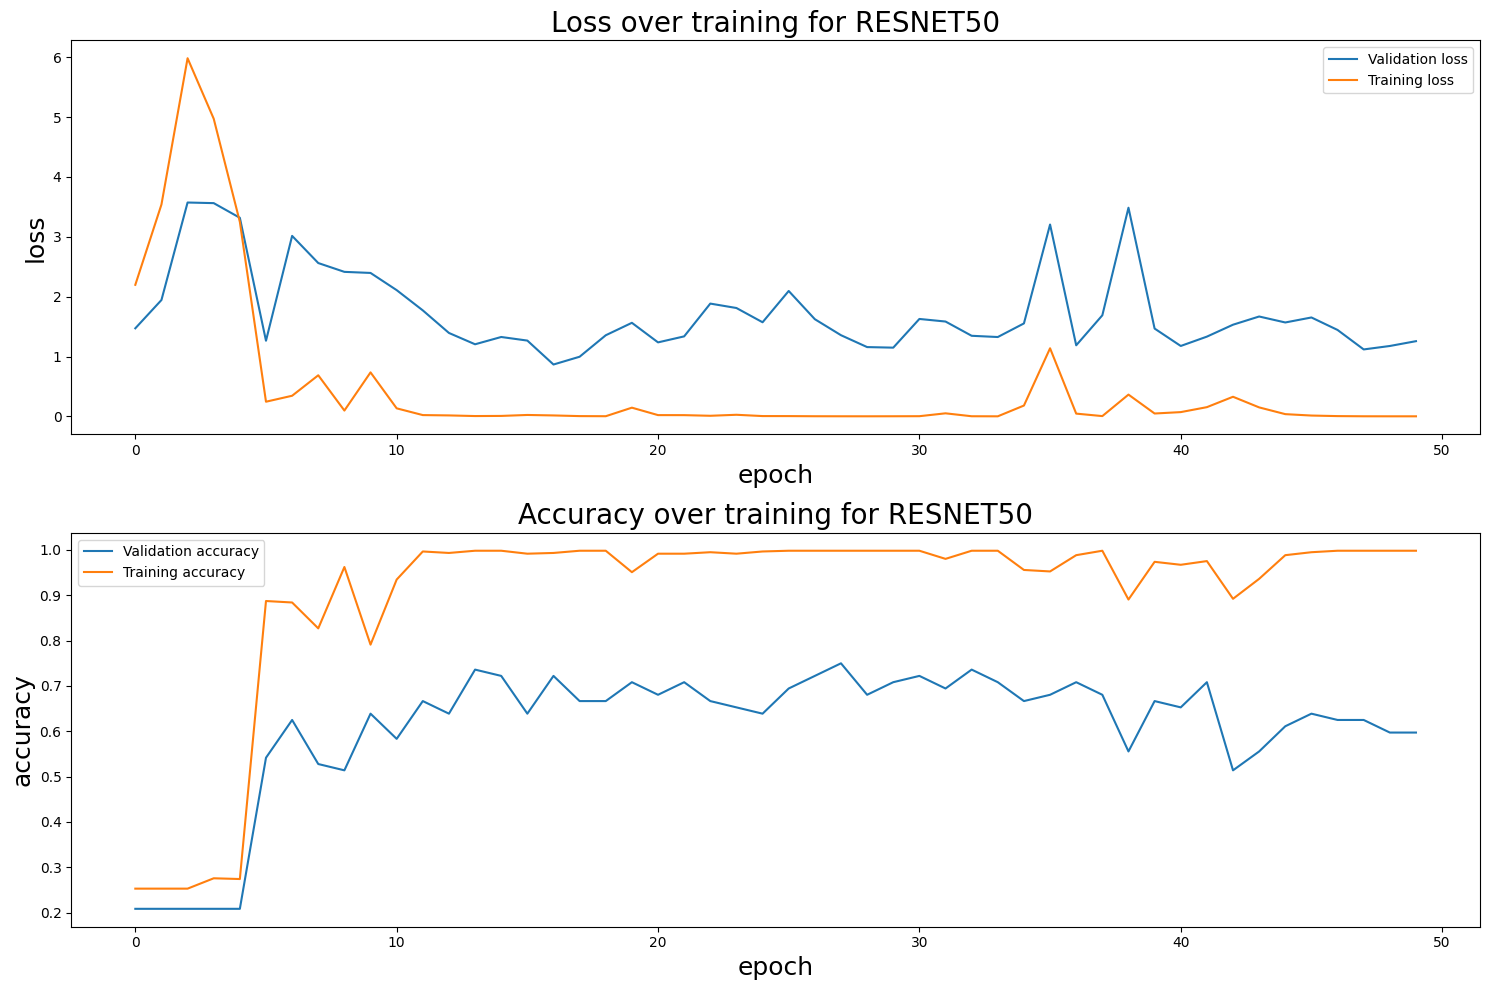

In [3]:
#with bigger batch_size:64
main("RESNET50",64)

cuda:0
Epoch: 1


100%|██████████| 10/10 [00:04<00:00,  2.57it/s]
10it [00:04,  2.40it/s]
100%|██████████| 10/10 [00:04<00:00,  2.40it/s]



	train Loss: 2.211305	train acc: 0.252855 
	val Loss: 1.467351	val acc: 0.208333
Epoch: 2


100%|██████████| 10/10 [00:03<00:00,  2.57it/s]
10it [00:03,  2.63it/s]
100%|██████████| 10/10 [00:03<00:00,  2.62it/s]



	train Loss: 3.984203	train acc: 0.252855 
	val Loss: 2.263154	val acc: 0.208333
Epoch: 3


100%|██████████| 10/10 [00:03<00:00,  2.57it/s]
10it [00:03,  2.61it/s]
100%|██████████| 10/10 [00:03<00:00,  2.61it/s]



	train Loss: 6.921451	train acc: 0.252855 
	val Loss: 4.297807	val acc: 0.208333
Epoch: 4


100%|██████████| 10/10 [00:03<00:00,  2.56it/s]
10it [00:03,  2.62it/s]
100%|██████████| 10/10 [00:03<00:00,  2.61it/s]



	train Loss: 7.379079	train acc: 0.264274 
	val Loss: 5.549133	val acc: 0.208333
Epoch: 5


100%|██████████| 10/10 [00:03<00:00,  2.55it/s]
10it [00:03,  2.63it/s]
100%|██████████| 10/10 [00:03<00:00,  2.61it/s]



	train Loss: 0.623912	train acc: 0.740620 
	val Loss: 1.555072	val acc: 0.333333
Epoch: 6


100%|██████████| 10/10 [00:03<00:00,  2.56it/s]
10it [00:03,  2.62it/s]
100%|██████████| 10/10 [00:03<00:00,  2.61it/s]



	train Loss: 0.288545	train acc: 0.877651 
	val Loss: 2.603732	val acc: 0.625000
Epoch: 7


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]
10it [00:03,  2.60it/s]
100%|██████████| 10/10 [00:03<00:00,  2.59it/s]



	train Loss: 0.470219	train acc: 0.858075 
	val Loss: 3.213408	val acc: 0.486111
Epoch: 8


100%|██████████| 10/10 [00:03<00:00,  2.55it/s]
10it [00:03,  2.60it/s]
100%|██████████| 10/10 [00:03<00:00,  2.59it/s]



	train Loss: 0.181384	train acc: 0.944535 
	val Loss: 3.024068	val acc: 0.569444
Epoch: 9


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
10it [00:03,  2.59it/s]
100%|██████████| 10/10 [00:03<00:00,  2.59it/s]



	train Loss: 2.319049	train acc: 0.613377 
	val Loss: 4.025828	val acc: 0.541667
Epoch: 10


100%|██████████| 10/10 [00:03<00:00,  2.55it/s]
10it [00:03,  2.57it/s]
100%|██████████| 10/10 [00:03<00:00,  2.57it/s]



	train Loss: 3.732460	train acc: 0.487765 
	val Loss: 5.897249	val acc: 0.500000
Epoch: 11


100%|██████████| 10/10 [00:03<00:00,  2.55it/s]
10it [00:03,  2.59it/s]
100%|██████████| 10/10 [00:03<00:00,  2.59it/s]



	train Loss: 1.137935	train acc: 0.727569 
	val Loss: 3.327184	val acc: 0.555556
Epoch: 12


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
10it [00:03,  2.58it/s]
100%|██████████| 10/10 [00:03<00:00,  2.58it/s]



	train Loss: 0.724343	train acc: 0.845024 
	val Loss: 3.030896	val acc: 0.555556
Epoch: 13


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
10it [00:03,  2.57it/s]
100%|██████████| 10/10 [00:03<00:00,  2.57it/s]



	train Loss: 0.304039	train acc: 0.872757 
	val Loss: 1.890077	val acc: 0.430556
Epoch: 14


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
10it [00:03,  2.58it/s]
100%|██████████| 10/10 [00:03<00:00,  2.58it/s]



	train Loss: 0.064076	train acc: 0.985318 
	val Loss: 1.526343	val acc: 0.597222
Epoch: 15


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]
10it [00:03,  2.57it/s]
100%|██████████| 10/10 [00:03<00:00,  2.57it/s]



	train Loss: 0.020196	train acc: 0.991843 
	val Loss: 2.075958	val acc: 0.652778
Epoch: 16


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]
10it [00:03,  2.62it/s]
100%|██████████| 10/10 [00:03<00:00,  2.61it/s]



	train Loss: 0.036687	train acc: 0.991843 
	val Loss: 1.917251	val acc: 0.694444
Epoch: 17


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]
10it [00:03,  2.59it/s]
100%|██████████| 10/10 [00:03<00:00,  2.59it/s]



	train Loss: 0.010736	train acc: 0.998369 
	val Loss: 1.567690	val acc: 0.625000
Epoch: 18


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]
10it [00:03,  2.59it/s]
100%|██████████| 10/10 [00:03<00:00,  2.59it/s]



	train Loss: 0.007877	train acc: 0.998369 
	val Loss: 1.340861	val acc: 0.638889
Epoch: 19


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]
10it [00:03,  2.61it/s]
100%|██████████| 10/10 [00:03<00:00,  2.60it/s]



	train Loss: 0.014977	train acc: 0.998369 
	val Loss: 1.758347	val acc: 0.652778
Epoch: 20


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]
10it [00:03,  2.54it/s]
100%|██████████| 10/10 [00:03<00:00,  2.54it/s]



	train Loss: 1.322415	train acc: 0.939641 
	val Loss: 2.541919	val acc: 0.680556
Epoch: 21


100%|██████████| 10/10 [00:03<00:00,  2.55it/s]
10it [00:03,  2.61it/s]
100%|██████████| 10/10 [00:03<00:00,  2.61it/s]



	train Loss: 0.005754	train acc: 0.998369 
	val Loss: 1.237280	val acc: 0.638889
Epoch: 22


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
10it [00:03,  2.56it/s]
100%|██████████| 10/10 [00:03<00:00,  2.56it/s]



	train Loss: 0.039783	train acc: 0.982055 
	val Loss: 1.167089	val acc: 0.694444
Epoch: 23


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
10it [00:03,  2.57it/s]
100%|██████████| 10/10 [00:03<00:00,  2.57it/s]



	train Loss: 0.031067	train acc: 0.995106 
	val Loss: 1.493108	val acc: 0.694444
Epoch: 24


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]
10it [00:03,  2.58it/s]
100%|██████████| 10/10 [00:03<00:00,  2.57it/s]



	train Loss: 0.002920	train acc: 0.998369 
	val Loss: 1.376260	val acc: 0.694444
Epoch: 25


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
10it [00:03,  2.57it/s]
100%|██████████| 10/10 [00:03<00:00,  2.57it/s]



	train Loss: 0.003176	train acc: 0.998369 
	val Loss: 1.633324	val acc: 0.722222
Epoch: 26


100%|██████████| 10/10 [00:03<00:00,  2.52it/s]
10it [00:03,  2.56it/s]
100%|██████████| 10/10 [00:03<00:00,  2.56it/s]



	train Loss: 0.003588	train acc: 0.998369 
	val Loss: 1.659458	val acc: 0.666667
Epoch: 27


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
10it [00:03,  2.60it/s]
100%|██████████| 10/10 [00:03<00:00,  2.59it/s]



	train Loss: 0.018338	train acc: 0.993475 
	val Loss: 1.120021	val acc: 0.680556
Epoch: 28


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
10it [00:03,  2.56it/s]
100%|██████████| 10/10 [00:03<00:00,  2.56it/s]



	train Loss: 0.015449	train acc: 0.998369 
	val Loss: 1.134643	val acc: 0.666667
Epoch: 29


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]
10it [00:03,  2.59it/s]
100%|██████████| 10/10 [00:03<00:00,  2.59it/s]



	train Loss: 0.004810	train acc: 0.996737 
	val Loss: 1.444730	val acc: 0.680556
Epoch: 30


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
10it [00:03,  2.56it/s]
100%|██████████| 10/10 [00:03<00:00,  2.56it/s]



	train Loss: 0.003887	train acc: 0.998369 
	val Loss: 1.115775	val acc: 0.722222
Epoch: 31


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
10it [00:03,  2.59it/s]
100%|██████████| 10/10 [00:03<00:00,  2.59it/s]



	train Loss: 0.007308	train acc: 0.996737 
	val Loss: 0.829188	val acc: 0.763889
Epoch: 32


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
10it [00:03,  2.55it/s]
100%|██████████| 10/10 [00:03<00:00,  2.55it/s]



	train Loss: 0.003075	train acc: 0.998369 
	val Loss: 1.951848	val acc: 0.722222
Epoch: 33


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
10it [00:03,  2.57it/s]
100%|██████████| 10/10 [00:03<00:00,  2.57it/s]



	train Loss: 0.081384	train acc: 0.965742 
	val Loss: 2.882781	val acc: 0.555556
Epoch: 34


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
10it [00:03,  2.56it/s]
100%|██████████| 10/10 [00:03<00:00,  2.56it/s]



	train Loss: 0.188354	train acc: 0.951060 
	val Loss: 1.169355	val acc: 0.680556
Epoch: 35


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]
10it [00:03,  2.59it/s]
100%|██████████| 10/10 [00:03<00:00,  2.59it/s]



	train Loss: 0.056363	train acc: 0.978793 
	val Loss: 1.720801	val acc: 0.652778
Epoch: 36


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
10it [00:03,  2.61it/s]
100%|██████████| 10/10 [00:03<00:00,  2.61it/s]



	train Loss: 0.116395	train acc: 0.964111 
	val Loss: 1.125850	val acc: 0.708333
Epoch: 37


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
10it [00:03,  2.56it/s]
100%|██████████| 10/10 [00:03<00:00,  2.56it/s]



	train Loss: 0.014890	train acc: 0.995106 
	val Loss: 1.015060	val acc: 0.708333
Epoch: 38


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
10it [00:03,  2.59it/s]
100%|██████████| 10/10 [00:03<00:00,  2.59it/s]



	train Loss: 0.009071	train acc: 0.996737 
	val Loss: 1.591236	val acc: 0.680556
Epoch: 39


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
10it [00:03,  2.60it/s]
100%|██████████| 10/10 [00:03<00:00,  2.60it/s]



	train Loss: 0.007527	train acc: 0.998369 
	val Loss: 1.392790	val acc: 0.638889
Epoch: 40


100%|██████████| 10/10 [00:03<00:00,  2.52it/s]
10it [00:03,  2.58it/s]
100%|██████████| 10/10 [00:03<00:00,  2.58it/s]



	train Loss: 0.059291	train acc: 0.982055 
	val Loss: 1.231918	val acc: 0.666667


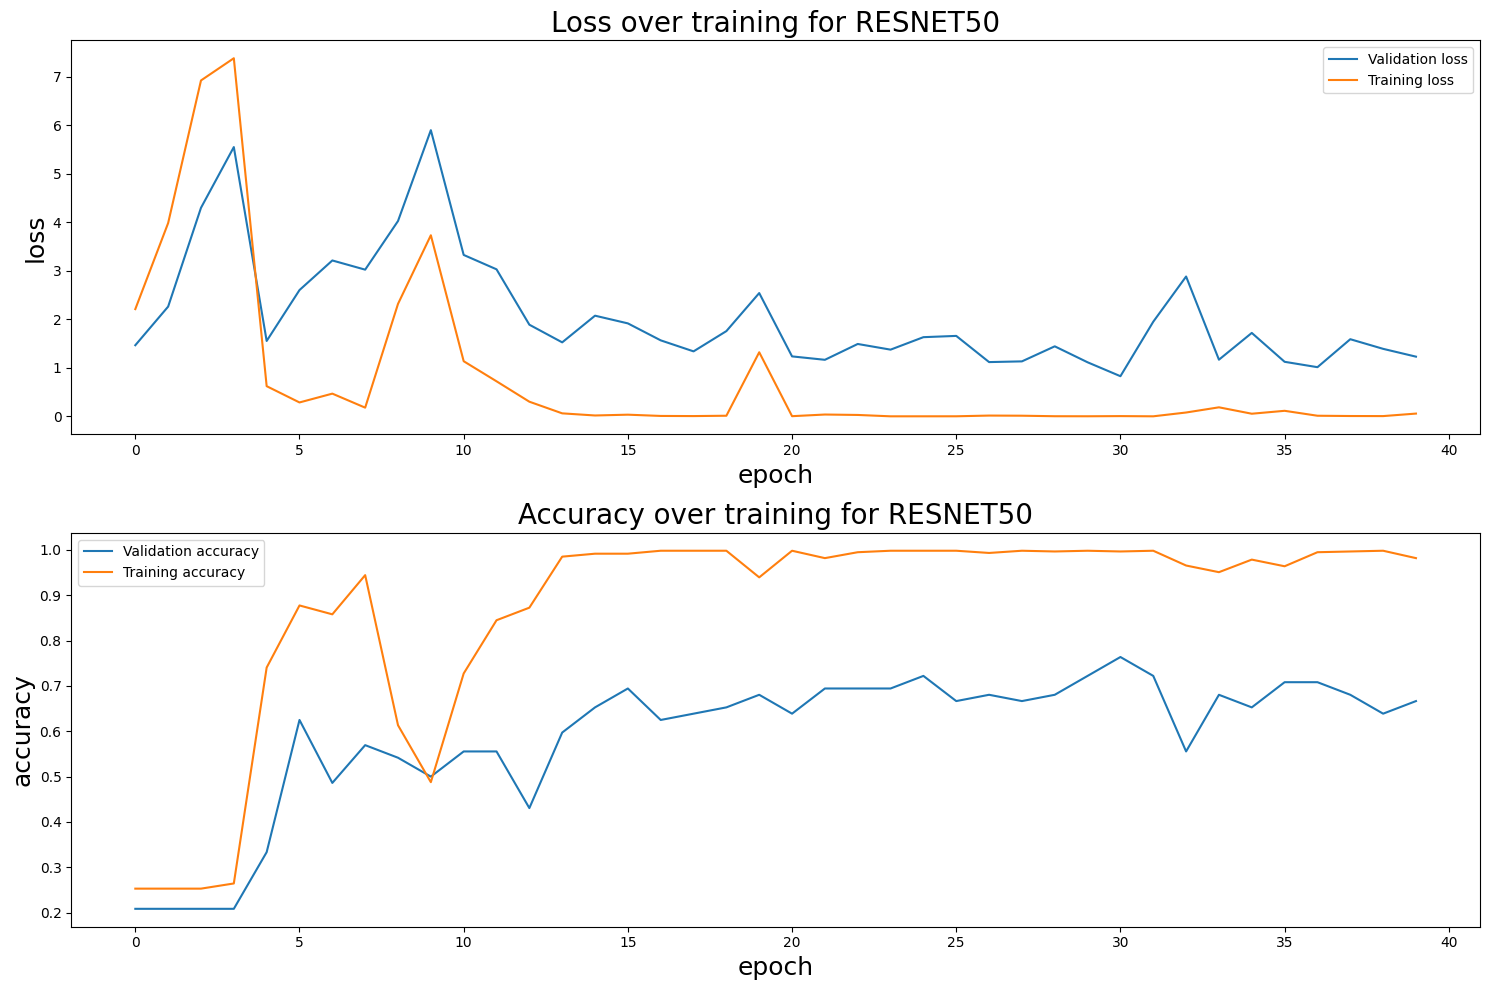

In [4]:
main("RESNET50",64)#epoch 40

# Resnet18

using cuda:0 device.
using 613 images for training, 72 images for validation.
Epoch: 1


100%|██████████| 20/20 [00:03<00:00,  7.92it/s]
20it [00:03,  5.91it/s]
100%|██████████| 20/20 [00:03<00:00,  5.90it/s]



	train Loss: 0.572840	train acc: 0.709625 
	val Loss: 0.945974	val acc: 0.500000
Epoch: 2


 95%|█████████▌| 19/20 [00:02<00:00,  6.69it/s]
20it [00:02,  6.82it/s]
100%|██████████| 20/20 [00:02<00:00,  6.81it/s]



	train Loss: 0.113141	train acc: 0.985318 
	val Loss: 0.553449	val acc: 0.791667
Epoch: 3


 95%|█████████▌| 19/20 [00:02<00:00,  6.88it/s]
20it [00:02,  6.99it/s]
100%|██████████| 20/20 [00:02<00:00,  6.99it/s]



	train Loss: 0.015777	train acc: 0.998369 
	val Loss: 0.314658	val acc: 0.902778
Epoch: 4


 95%|█████████▌| 19/20 [00:02<00:00,  6.63it/s]
20it [00:02,  6.83it/s]
100%|██████████| 20/20 [00:02<00:00,  6.83it/s]



	train Loss: 0.013434	train acc: 0.998369 
	val Loss: 0.305298	val acc: 0.888889
Epoch: 5


 95%|█████████▌| 19/20 [00:02<00:00,  6.78it/s]
20it [00:02,  6.90it/s]
100%|██████████| 20/20 [00:02<00:00,  6.90it/s]



	train Loss: 0.026495	train acc: 0.998369 
	val Loss: 0.347036	val acc: 0.833333
Epoch: 6


 95%|█████████▌| 19/20 [00:02<00:00,  6.99it/s]
20it [00:02,  6.96it/s]
100%|██████████| 20/20 [00:02<00:00,  6.95it/s]



	train Loss: 0.005412	train acc: 0.998369 
	val Loss: 0.276319	val acc: 0.875000
Epoch: 7


 95%|█████████▌| 19/20 [00:02<00:00,  7.05it/s]
20it [00:02,  6.75it/s]
100%|██████████| 20/20 [00:02<00:00,  6.74it/s]



	train Loss: 0.010506	train acc: 0.998369 
	val Loss: 0.253791	val acc: 0.888889
Epoch: 8


 95%|█████████▌| 19/20 [00:02<00:00,  6.81it/s]
20it [00:02,  6.92it/s]
100%|██████████| 20/20 [00:02<00:00,  6.91it/s]



	train Loss: 0.003566	train acc: 0.998369 
	val Loss: 0.266241	val acc: 0.888889
Epoch: 9


 95%|█████████▌| 19/20 [00:02<00:00,  7.05it/s]
20it [00:02,  6.88it/s]
100%|██████████| 20/20 [00:02<00:00,  6.88it/s]



	train Loss: 0.003064	train acc: 0.998369 
	val Loss: 0.269590	val acc: 0.888889
Epoch: 10


 95%|█████████▌| 19/20 [00:02<00:00,  6.81it/s]
20it [00:02,  7.01it/s]
100%|██████████| 20/20 [00:02<00:00,  7.01it/s]



	train Loss: 0.004160	train acc: 0.998369 
	val Loss: 0.271398	val acc: 0.902778
Total training time: 63.09 seconds.


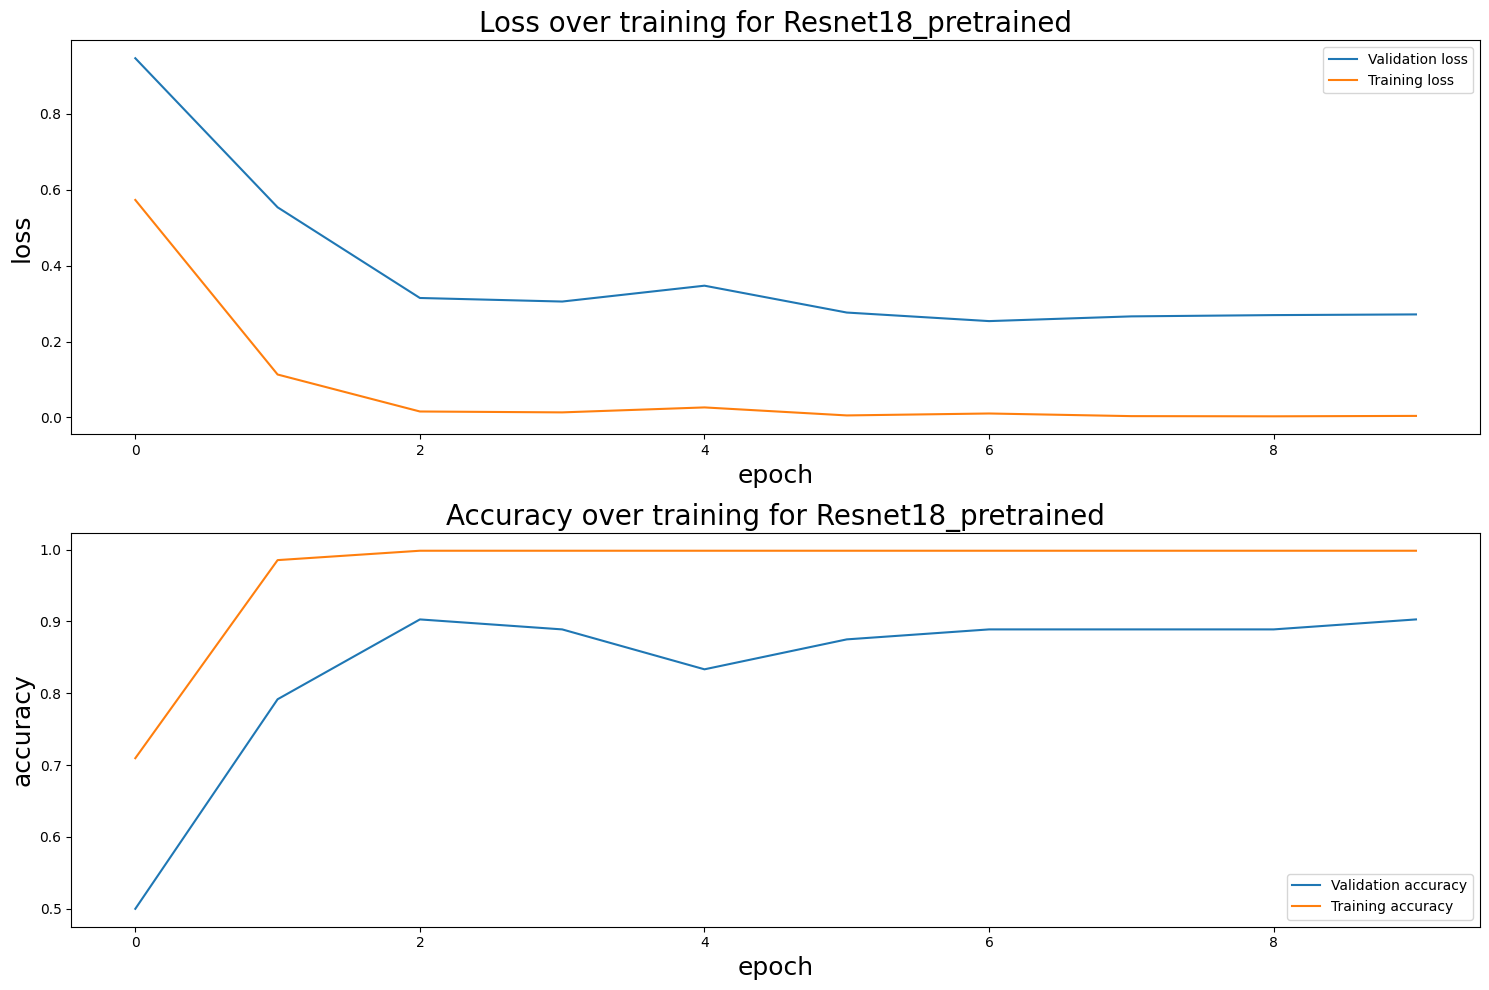

In [3]:
from __future__ import print_function

from utils.params import Params
from utils.plotting import plot_training

import os
import sys
import json
 
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from tqdm import tqdm

import torchvision.models.resnet


torch.cuda.empty_cache()
params = Params("hparams.yaml", 'RESNET_Pretrained')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    "val": transforms.Compose([transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}
if not os.path.exists(params.log_dir): os.makedirs(params.log_dir)
if not os.path.exists(params.checkpoint_dir): os.makedirs(params.checkpoint_dir)
if not os.path.exists("figs"): os.makedirs("figs")
# Dataset root directory
#data_dir = './Data/images_original'
#assert os.path.exists(data_dir), "{} path does not exist.".format(data_dir)

#dataset = [(data.to(device), target.to(device)) for data, target in dataset]
# Set random seed
torch.manual_seed(2024)
# Split dataset into training and testing sets

train_dataset = torchvision.datasets.ImageFolder(root="Data/train", transform=data_transform['val'])
test_dataset = torchvision.datasets.ImageFolder(root="Data/test", transform=data_transform['val'])        
val_dataset = torchvision.datasets.ImageFolder(root="Data/valid", transform=data_transform['val']) 

train_num = len(train_dataset)
# Create data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_num = len(val_dataset)
print("using {} images for training, {} images for validation.".format(train_num,
                                                                       val_num))


# Load model that has been chosen via the command line arguments.
model_module = __import__('.'.join(['models', params.model_name]),  fromlist=['object'])
net = model_module.net(model_module.BasicBlock, [2,2,2,2], 1000)
# load pretrain weights
# download url: https://download.pytorch.org/models/resnet34-333f7ec4.pth
model_weight_path = "./utils/resnet18-f37072fd.pth"
assert os.path.exists(model_weight_path), "file {} does not exist.".format(model_weight_path)
net.load_state_dict(torch.load(model_weight_path, map_location='cpu'))
# for param in net.parameters():
#     param.requires_grad = False

# change fc layer structure
in_channel = net.fc.in_features
net.fc = nn.Linear(in_channel, 4)
net.to(device)

# define loss function
loss_function = nn.CrossEntropyLoss()

# construct an optimizer
params = [p for p in net.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=0.0001)
import numpy as np
from sklearn.metrics import accuracy_score
import time
# 记录训练开始时间
start_time = time.time()
##train
val_accs = []
val_losses = []
train_losses = []
train_accs = []
def train(model, device, train_loader, optimizer):
    model.train()
    cost = nn.CrossEntropyLoss()
    with tqdm(total=len(train_loader)) as progress_bar:
        for batch_idx, (data, label) in tqdm(enumerate(train_loader)):
            data = data.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = cost(output, label)        
            loss.backward()
            optimizer.step()
            progress_bar.update(1)



def val(model, device, val_loader, checkpoint=None):
    if checkpoint is not None:
        model_state = torch.load(checkpoint)
        model.load_state_dict(model_state)     
    # Need this line for things like dropout etc.  
    model.eval()
    preds = []
    targets = []
    cost = nn.CrossEntropyLoss()
    losses = []
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(val_loader):
            data = data.to(device)
            label = label.to(device)
            target = label.clone()
            output = model(data)
            preds.append(output.cpu().numpy())
            targets.append(target.cpu().numpy())
            losses.append(cost(output, label).cpu().numpy())
    loss = np.mean(losses)
    preds = np.argmax(np.concatenate(preds), axis=1)
    targets  = np.concatenate(targets)
    acc = accuracy_score(targets, preds)
    return loss, acc
#with torch.no_grad():
for epoch in range(1, 11):
    torch.cuda.empty_cache()
    print("Epoch: {}".format(epoch))
    # Call training function.
    train(net, device, train_loader, optimizer)
    # Evaluate on both the training and validation set.
    train_loss, train_acc = val(net, device, train_loader)
    val_loss, val_acc = val(net, device, val_loader)
    # Collect some data for logging purposes.
    train_losses.append(float(train_loss))
    train_accs.append(train_acc)
    val_losses.append(float(val_loss))
    val_accs.append(val_acc)

    print('\n\ttrain Loss: {:.6f}\ttrain acc: {:.6f} \n\tval Loss: {:.6f}\tval acc: {:.6f}'.format(train_loss, train_acc, val_loss, val_acc))

    # Save model every few epochs (or even more often if you have the disk space).
    if epoch % 5 == 0:
        torch.save(net.state_dict(), os.path.join("checkpoints/resnet-pretrained","checkpoint_{}_epoch_{}".format("resnet18-pretrained",epoch)))
# 计算总的训练时间并打印
total_time = time.time() - start_time
print("Total training time: {:.2f} seconds.".format(total_time))
# Clear plot each epoch
fig = plot_training(train_losses, train_accs,val_losses, val_accs,'Resnet18_pretrained')
fig.savefig(os.path.join("figs", "{}_training_vis".format("Resnet18_pretrained")))
# Some log information to help you keep track of your model information.
logs ={
    "model": "Resnet_pretrained",
    #"model": args.model_name,
    "train_losses": train_losses,
    "train_accs": train_accs,
    "val_losses": val_losses,
    "val_accs": val_accs,
    "best_val_epoch": int(np.argmax(val_accs)+1),
    #"model": args.model_name,
    "model": "Resnet_pretrained",
    "lr": 0.0001,
    "batch_size":32
}
start_time = time.strftime("%d%m%y_%H%M%S")
with open(os.path.join('logs/resnet-pretrained',"{}_{}.json".format("Resnet18_pretrained",  start_time)), 'w') as f:
    json.dump(logs, f)


# Try pretrained resnet34

using cuda:0 device.
using 613 images for training, 72 images for validation.
Epoch: 1


100%|██████████| 20/20 [00:03<00:00,  7.60it/s]
20it [00:03,  5.87it/s]
100%|██████████| 20/20 [00:03<00:00,  5.86it/s]



	train Loss: 0.240934	train acc: 0.947798 
	val Loss: 0.631055	val acc: 0.722222
Epoch: 2


100%|██████████| 20/20 [00:03<00:00,  6.85it/s]
20it [00:03,  6.42it/s]
100%|██████████| 20/20 [00:03<00:00,  6.42it/s]



	train Loss: 0.134902	train acc: 0.957586 
	val Loss: 0.528098	val acc: 0.722222
Epoch: 3


100%|██████████| 20/20 [00:03<00:00,  7.13it/s]
20it [00:03,  6.55it/s]
100%|██████████| 20/20 [00:03<00:00,  6.55it/s]



	train Loss: 0.008845	train acc: 0.998369 
	val Loss: 0.254839	val acc: 0.875000
Epoch: 4


100%|██████████| 20/20 [00:03<00:00,  7.20it/s]
20it [00:03,  6.55it/s]
100%|██████████| 20/20 [00:03<00:00,  6.54it/s]



	train Loss: 0.011837	train acc: 0.996737 
	val Loss: 0.259733	val acc: 0.902778
Epoch: 5


100%|██████████| 20/20 [00:03<00:00,  7.06it/s]
20it [00:03,  6.51it/s]
100%|██████████| 20/20 [00:03<00:00,  6.50it/s]



	train Loss: 0.005942	train acc: 0.998369 
	val Loss: 0.316644	val acc: 0.861111
Epoch: 6


100%|██████████| 20/20 [00:03<00:00,  6.84it/s]
20it [00:03,  6.25it/s]
100%|██████████| 20/20 [00:03<00:00,  6.24it/s]



	train Loss: 0.040563	train acc: 0.991843 
	val Loss: 0.292256	val acc: 0.847222
Epoch: 7


100%|██████████| 20/20 [00:03<00:00,  6.39it/s]
20it [00:03,  6.05it/s]
100%|██████████| 20/20 [00:03<00:00,  6.04it/s]



	train Loss: 0.013395	train acc: 0.996737 
	val Loss: 0.313558	val acc: 0.902778
Epoch: 8


100%|██████████| 20/20 [00:03<00:00,  6.85it/s]
20it [00:03,  6.43it/s]
100%|██████████| 20/20 [00:03<00:00,  6.43it/s]



	train Loss: 0.055221	train acc: 0.991843 
	val Loss: 0.653589	val acc: 0.833333
Epoch: 9


100%|██████████| 20/20 [00:03<00:00,  6.79it/s]
20it [00:03,  6.19it/s]
100%|██████████| 20/20 [00:03<00:00,  6.18it/s]



	train Loss: 0.017302	train acc: 0.993475 
	val Loss: 0.210453	val acc: 0.930556
Epoch: 10


100%|██████████| 20/20 [00:03<00:00,  6.85it/s]
20it [00:03,  6.32it/s]
100%|██████████| 20/20 [00:03<00:00,  6.32it/s]



	train Loss: 0.015646	train acc: 0.998369 
	val Loss: 0.356387	val acc: 0.888889
Total training time: 68.36 seconds.


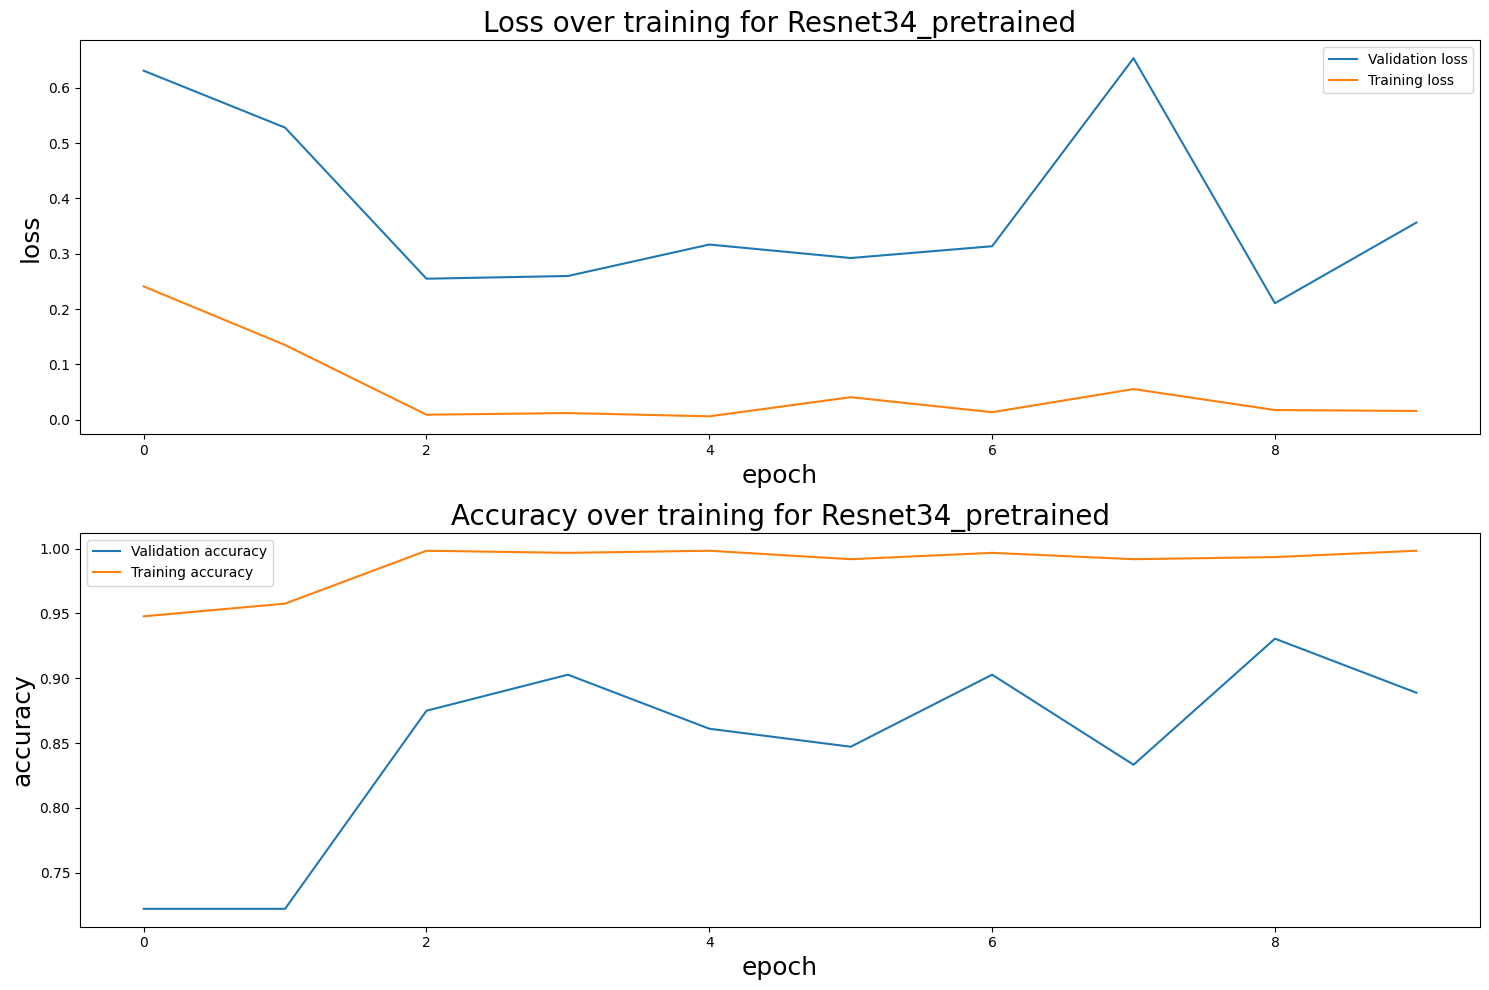

In [5]:
from __future__ import print_function

from utils.params import Params
from utils.plotting import plot_training

import os
import sys
import json
 
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from tqdm import tqdm

import torchvision.models.resnet


torch.cuda.empty_cache()
params = Params("hparams.yaml", 'RESNET_Pretrained')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    "val": transforms.Compose([transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}
if not os.path.exists(params.log_dir): os.makedirs(params.log_dir)
if not os.path.exists(params.checkpoint_dir): os.makedirs(params.checkpoint_dir)
if not os.path.exists("figs"): os.makedirs("figs")
# Dataset root directory
train_dataset = torchvision.datasets.ImageFolder(root="Data/train", transform=data_transform['val'])
test_dataset = torchvision.datasets.ImageFolder(root="Data/test", transform=data_transform['val'])        
val_dataset = torchvision.datasets.ImageFolder(root="Data/valid", transform=data_transform['val']) 
train_num = len(train_dataset)
# Create data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_num = len(val_dataset)
print("using {} images for training, {} images for validation.".format(train_num,
                                                                       val_num))


# Load model that has been chosen via the command line arguments.
model_module = __import__('.'.join(['models', params.model_name]),  fromlist=['object'])
net = model_module.net(model_module.BasicBlock, [3, 4, 6, 3], 1000)
# load pretrain weights
# download url: https://download.pytorch.org/models/resnet34-333f7ec4.pth
model_weight_path = "./utils/resnet34-333f7ec4.pth"
assert os.path.exists(model_weight_path), "file {} does not exist.".format(model_weight_path)
net.load_state_dict(torch.load(model_weight_path, map_location='cpu'))
# for param in net.parameters():
#     param.requires_grad = False

# change fc layer structure
in_channel = net.fc.in_features
net.fc = nn.Linear(in_channel, 4)
net.to(device)

# define loss function
loss_function = nn.CrossEntropyLoss()

# construct an optimizer
params = [p for p in net.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=0.0001)

epochs = 10
best_acc = 0.0
save_path = './resNet34.pth'
train_steps = len(train_loader)

import numpy as np
from sklearn.metrics import accuracy_score
import time
##train
# 记录训练开始时间
start_time = time.time()
val_accs = []
val_losses = []
train_losses = []
train_accs = []
def train(model, device, train_loader, optimizer):
    model.train()
    cost = nn.CrossEntropyLoss()
    with tqdm(total=len(train_loader)) as progress_bar:
        for batch_idx, (data, label) in tqdm(enumerate(train_loader)):
            data = data.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = cost(output, label)        
            loss.backward()
            optimizer.step()
            progress_bar.update(1)



def val(model, device, val_loader, checkpoint=None):
    if checkpoint is not None:
        model_state = torch.load(checkpoint)
        model.load_state_dict(model_state)     
    # Need this line for things like dropout etc.  
    model.eval()
    preds = []
    targets = []
    cost = nn.CrossEntropyLoss()
    losses = []
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(val_loader):
            data = data.to(device)
            label = label.to(device)
            target = label.clone()
            output = model(data)
            preds.append(output.cpu().numpy())
            targets.append(target.cpu().numpy())
            losses.append(cost(output, label).cpu().numpy())
    loss = np.mean(losses)
    preds = np.argmax(np.concatenate(preds), axis=1)
    targets  = np.concatenate(targets)
    acc = accuracy_score(targets, preds)
    return loss, acc
#with torch.no_grad():
for epoch in range(1, 11):
    torch.cuda.empty_cache()
    print("Epoch: {}".format(epoch))
    # Call training function.
    train(net, device, train_loader, optimizer)
    # Evaluate on both the training and validation set.
    train_loss, train_acc = val(net, device, train_loader)
    val_loss, val_acc = val(net, device, val_loader)
    # Collect some data for logging purposes.
    train_losses.append(float(train_loss))
    train_accs.append(train_acc)
    val_losses.append(float(val_loss))
    val_accs.append(val_acc)

    print('\n\ttrain Loss: {:.6f}\ttrain acc: {:.6f} \n\tval Loss: {:.6f}\tval acc: {:.6f}'.format(train_loss, train_acc, val_loss, val_acc))

    # Save model every few epochs (or even more often if you have the disk space).
    if epoch % 5 == 0:
        torch.save(net.state_dict(), os.path.join("checkpoints/resnet-pretrained","checkpoint_{}_epoch_{}".format("resnet34-pretrained",epoch)))
# 计算总的训练时间并打印
total_time = time.time() - start_time
print("Total training time: {:.2f} seconds.".format(total_time))
# Clear plot each epoch
fig = plot_training(train_losses, train_accs,val_losses, val_accs,'Resnet34_pretrained')
fig.savefig(os.path.join("figs", "{}_training_vis".format("Resnet34_pretrained")))
# Some log information to help you keep track of your model information.
logs ={
    "model": "Resnet_pretrained",
    #"model": args.model_name,
    "train_losses": train_losses,
    "train_accs": train_accs,
    "val_losses": val_losses,
    "val_accs": val_accs,
    "best_val_epoch": int(np.argmax(val_accs)+1),
    #"model": args.model_name,
    "model": "Resnet_pretrained",
    "lr": 0.0001,
    "batch_size":32
}
start_time = time.strftime("%d%m%y_%H%M%S")
with open(os.path.join('logs/resnet-pretrained',"{}_{}.json".format("Resnet34_pretrained",  start_time)), 'w') as f:
    json.dump(logs, f)


using cuda:0 device.
using 613 images for training, 72 images for validation.
Epoch: 1


100%|██████████| 20/20 [00:03<00:00,  7.50it/s]
20it [00:03,  6.13it/s]
100%|██████████| 20/20 [00:03<00:00,  6.13it/s]



	train Loss: 0.249624	train acc: 0.939641 
	val Loss: 0.636622	val acc: 0.736111
Epoch: 2


100%|██████████| 20/20 [00:02<00:00,  7.08it/s]
20it [00:02,  6.71it/s]
100%|██████████| 20/20 [00:02<00:00,  6.71it/s]



	train Loss: 0.136154	train acc: 0.954323 
	val Loss: 0.514616	val acc: 0.736111
Epoch: 3


100%|██████████| 20/20 [00:02<00:00,  7.18it/s]
20it [00:02,  6.71it/s]
100%|██████████| 20/20 [00:02<00:00,  6.69it/s]



	train Loss: 0.009516	train acc: 0.998369 
	val Loss: 0.264788	val acc: 0.875000
Epoch: 4


100%|██████████| 20/20 [00:03<00:00,  6.87it/s]
20it [00:03,  6.44it/s]
100%|██████████| 20/20 [00:03<00:00,  6.44it/s]



	train Loss: 0.021744	train acc: 0.996737 
	val Loss: 0.321165	val acc: 0.875000
Epoch: 5


100%|██████████| 20/20 [00:02<00:00,  7.08it/s]
20it [00:02,  6.70it/s]
100%|██████████| 20/20 [00:02<00:00,  6.68it/s]



	train Loss: 0.005699	train acc: 0.998369 
	val Loss: 0.306208	val acc: 0.875000
Epoch: 6


100%|██████████| 20/20 [00:03<00:00,  7.20it/s]
20it [00:03,  6.38it/s]
100%|██████████| 20/20 [00:03<00:00,  6.38it/s]



	train Loss: 0.027495	train acc: 0.988581 
	val Loss: 0.413256	val acc: 0.805556
Epoch: 7


100%|██████████| 20/20 [00:03<00:00,  6.47it/s]
20it [00:03,  6.18it/s]
100%|██████████| 20/20 [00:03<00:00,  6.18it/s]



	train Loss: 0.015469	train acc: 0.998369 
	val Loss: 0.271752	val acc: 0.875000
Epoch: 8


100%|██████████| 20/20 [00:03<00:00,  6.88it/s]
20it [00:03,  6.37it/s]
100%|██████████| 20/20 [00:03<00:00,  6.37it/s]



	train Loss: 0.049528	train acc: 0.988581 
	val Loss: 0.656541	val acc: 0.763889
Epoch: 9


100%|██████████| 20/20 [00:03<00:00,  6.85it/s]
20it [00:03,  6.41it/s]
100%|██████████| 20/20 [00:03<00:00,  6.41it/s]



	train Loss: 0.056747	train acc: 0.975530 
	val Loss: 0.550646	val acc: 0.777778
Epoch: 10


100%|██████████| 20/20 [00:03<00:00,  6.82it/s]
20it [00:03,  6.50it/s]
100%|██████████| 20/20 [00:03<00:00,  6.48it/s]



	train Loss: 0.015352	train acc: 0.996737 
	val Loss: 0.282708	val acc: 0.847222


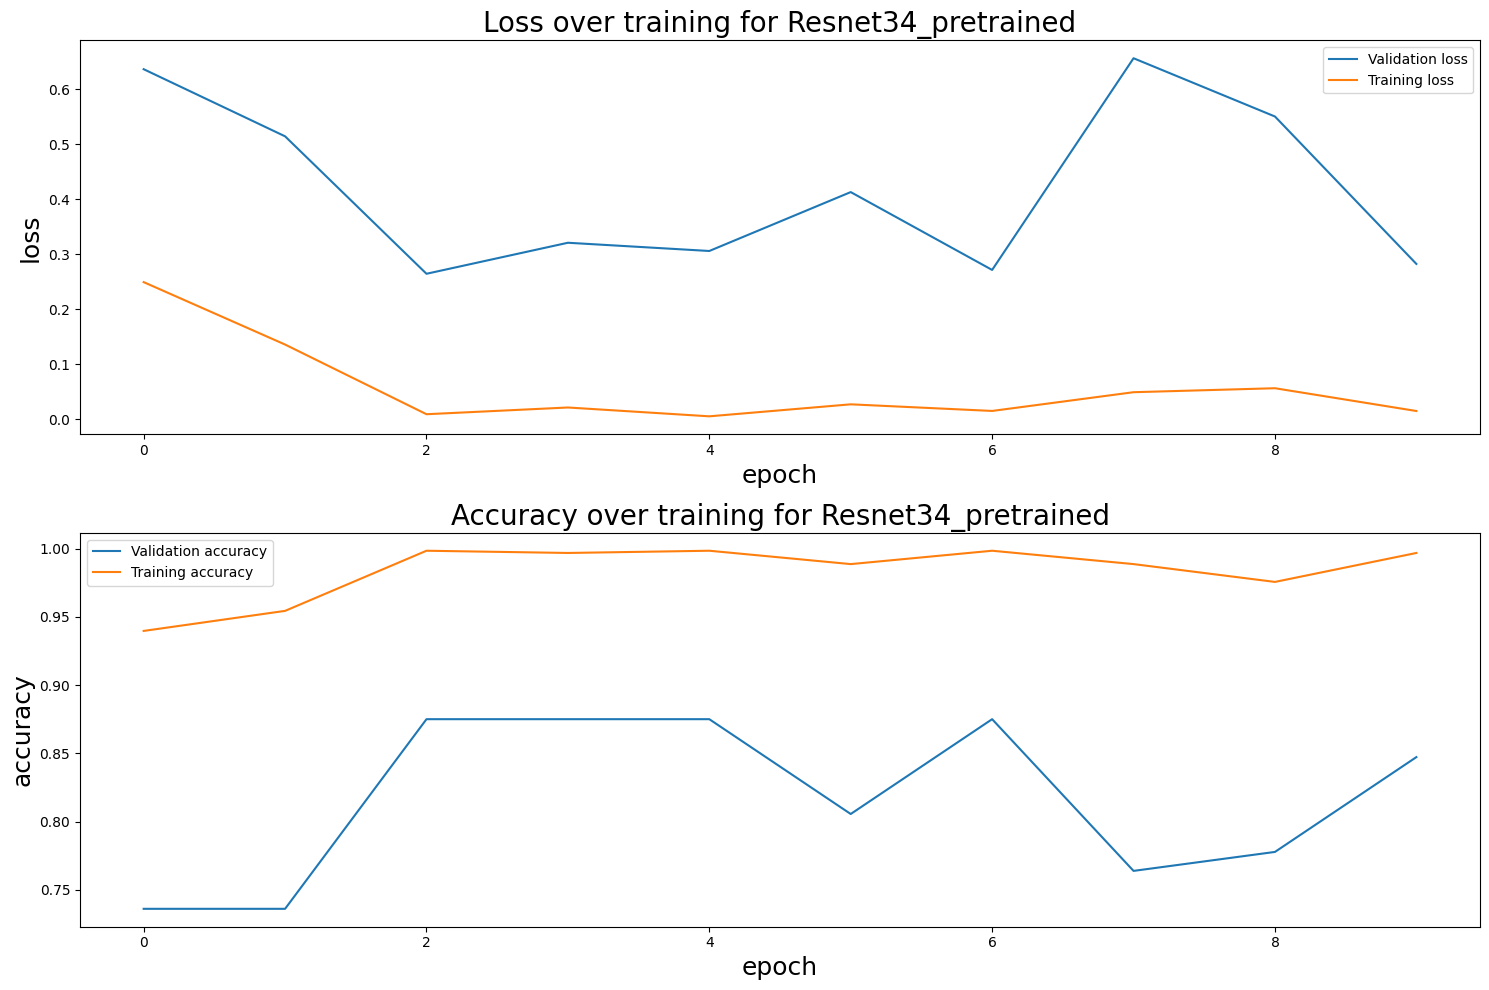

In [9]:
#try more epoches with resnet34
from __future__ import print_function

from utils.params import Params
from utils.plotting import plot_training

import os
import sys
import json
 
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from tqdm import tqdm

import torchvision.models.resnet


torch.cuda.empty_cache()
params = Params("hparams.yaml", 'RESNET_Pretrained')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    "val": transforms.Compose([transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}
if not os.path.exists(params.log_dir): os.makedirs(params.log_dir)
if not os.path.exists(params.checkpoint_dir): os.makedirs(params.checkpoint_dir)
if not os.path.exists("figs"): os.makedirs("figs")
# Dataset root directory
train_dataset = torchvision.datasets.ImageFolder(root="Data/train", transform=data_transform['val'])
test_dataset = torchvision.datasets.ImageFolder(root="Data/test", transform=data_transform['val'])        
val_dataset = torchvision.datasets.ImageFolder(root="Data/valid", transform=data_transform['val']) 
train_num = len(train_dataset)
# Create data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_num = len(val_dataset)
print("using {} images for training, {} images for validation.".format(train_num,
                                                                       val_num))


# Load model that has been chosen via the command line arguments.
model_module = __import__('.'.join(['models', params.model_name]),  fromlist=['object'])
net = model_module.net(model_module.BasicBlock, [3, 4, 6, 3], 1000)
# load pretrain weights
# download url: https://download.pytorch.org/models/resnet34-333f7ec4.pth
model_weight_path = "./utils/resnet34-333f7ec4.pth"
assert os.path.exists(model_weight_path), "file {} does not exist.".format(model_weight_path)
net.load_state_dict(torch.load(model_weight_path, map_location='cpu'))
# for param in net.parameters():
#     param.requires_grad = False

# change fc layer structure
in_channel = net.fc.in_features
net.fc = nn.Linear(in_channel, 4)
net.to(device)

# define loss function
loss_function = nn.CrossEntropyLoss()

# construct an optimizer
params = [p for p in net.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=0.0001)

epochs = 20
best_acc = 0.0
save_path = './resNet34.pth'
train_steps = len(train_loader)

import numpy as np
from sklearn.metrics import accuracy_score
import time
##train
val_accs = []
val_losses = []
train_losses = []
train_accs = []
def train(model, device, train_loader, optimizer):
    model.train()
    cost = nn.CrossEntropyLoss()
    with tqdm(total=len(train_loader)) as progress_bar:
        for batch_idx, (data, label) in tqdm(enumerate(train_loader)):
            data = data.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = cost(output, label)        
            loss.backward()
            optimizer.step()
            progress_bar.update(1)



def val(model, device, val_loader, checkpoint=None):
    if checkpoint is not None:
        model_state = torch.load(checkpoint)
        model.load_state_dict(model_state)     
    # Need this line for things like dropout etc.  
    model.eval()
    preds = []
    targets = []
    cost = nn.CrossEntropyLoss()
    losses = []
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(val_loader):
            data = data.to(device)
            label = label.to(device)
            target = label.clone()
            output = model(data)
            preds.append(output.cpu().numpy())
            targets.append(target.cpu().numpy())
            losses.append(cost(output, label).cpu().numpy())
    loss = np.mean(losses)
    preds = np.argmax(np.concatenate(preds), axis=1)
    targets  = np.concatenate(targets)
    acc = accuracy_score(targets, preds)
    return loss, acc
#with torch.no_grad():
for epoch in range(1, 11):
    torch.cuda.empty_cache()
    print("Epoch: {}".format(epoch))
    # Call training function.
    train(net, device, train_loader, optimizer)
    # Evaluate on both the training and validation set.
    train_loss, train_acc = val(net, device, train_loader)
    val_loss, val_acc = val(net, device, val_loader)
    # Collect some data for logging purposes.
    train_losses.append(float(train_loss))
    train_accs.append(train_acc)
    val_losses.append(float(val_loss))
    val_accs.append(val_acc)

    print('\n\ttrain Loss: {:.6f}\ttrain acc: {:.6f} \n\tval Loss: {:.6f}\tval acc: {:.6f}'.format(train_loss, train_acc, val_loss, val_acc))

    # Save model every few epochs (or even more often if you have the disk space).
    if epoch % 5 == 0:
        torch.save(net.state_dict(), os.path.join("checkpoints/resnet-pretrained","checkpoint_{}_epoch_{}".format("resnet34-pretrained",epoch)))
# Clear plot each epoch
fig = plot_training(train_losses, train_accs,val_losses, val_accs,'Resnet34_pretrained')
fig.savefig(os.path.join("figs", "{}_training_vis".format("Resnet34_pretrained")))
# Some log information to help you keep track of your model information.
logs ={
    "model": "Resnet_pretrained",
    #"model": args.model_name,
    "train_losses": train_losses,
    "train_accs": train_accs,
    "val_losses": val_losses,
    "val_accs": val_accs,
    "best_val_epoch": int(np.argmax(val_accs)+1),
    #"model": args.model_name,
    "model": "Resnet_pretrained",
    "lr": 0.0001,
    "batch_size":32
}
start_time = time.strftime("%d%m%y_%H%M%S")
with open(os.path.join('logs/resnet-pretrained',"{}_{}.json".format("Resnet34_pretrained",  start_time)), 'w') as f:
    json.dump(logs, f)



# Try on Histopathological image

using cuda:0 device.
using 10800 images for training, 2700 images for validation.
Epoch: 1


100%|██████████| 338/338 [01:56<00:00,  3.03it/s]
338it [01:56,  2.90it/s]
100%|██████████| 338/338 [01:56<00:00,  2.90it/s]



	train Loss: 0.013450	train acc: 0.996667 
	val Loss: 0.020707	val acc: 0.994444
Epoch: 2


100%|██████████| 338/338 [01:44<00:00,  3.75it/s]
338it [01:44,  3.24it/s]
100%|██████████| 338/338 [01:44<00:00,  3.24it/s]



	train Loss: 0.001880	train acc: 0.999907 
	val Loss: 0.011227	val acc: 0.995926
Epoch: 3


100%|██████████| 338/338 [01:44<00:00,  3.75it/s]
338it [01:44,  3.24it/s]
100%|██████████| 338/338 [01:44<00:00,  3.24it/s]



	train Loss: 0.014794	train acc: 0.995648 
	val Loss: 0.048312	val acc: 0.987407
Epoch: 4


100%|██████████| 338/338 [01:43<00:00,  3.70it/s]
338it [01:43,  3.26it/s]
100%|██████████| 338/338 [01:43<00:00,  3.26it/s]



	train Loss: 0.010520	train acc: 0.996296 
	val Loss: 0.035195	val acc: 0.988148
Epoch: 5


100%|██████████| 338/338 [01:43<00:00,  3.71it/s]
338it [01:43,  3.26it/s]
100%|██████████| 338/338 [01:43<00:00,  3.26it/s]



	train Loss: 0.000385	train acc: 0.999907 
	val Loss: 0.002719	val acc: 0.998889
Epoch: 6


100%|██████████| 338/338 [01:55<00:00,  3.34it/s]
338it [01:54,  2.94it/s]
100%|██████████| 338/338 [01:55<00:00,  2.94it/s]



	train Loss: 0.000053	train acc: 1.000000 
	val Loss: 0.003104	val acc: 0.998889
Epoch: 7


100%|██████████| 338/338 [01:53<00:00,  3.33it/s]
338it [01:53,  2.98it/s]
100%|██████████| 338/338 [01:53<00:00,  2.98it/s]



	train Loss: 0.018685	train acc: 0.994167 
	val Loss: 0.074633	val acc: 0.983333
Epoch: 8


100%|██████████| 338/338 [01:56<00:00,  3.29it/s]
338it [01:56,  2.90it/s]
100%|██████████| 338/338 [01:56<00:00,  2.90it/s]



	train Loss: 0.000911	train acc: 0.999815 
	val Loss: 0.004896	val acc: 0.998889
Epoch: 9


100%|██████████| 338/338 [01:55<00:00,  3.57it/s]
338it [01:55,  2.93it/s]
100%|██████████| 338/338 [01:55<00:00,  2.93it/s]



	train Loss: 0.000110	train acc: 1.000000 
	val Loss: 0.002844	val acc: 0.999259
Epoch: 10


100%|██████████| 338/338 [01:53<00:00,  3.55it/s]
338it [01:53,  2.98it/s]
100%|██████████| 338/338 [01:53<00:00,  2.98it/s]



	train Loss: 0.000040	train acc: 1.000000 
	val Loss: 0.003196	val acc: 0.998889
Total training time: 2702.42 seconds.


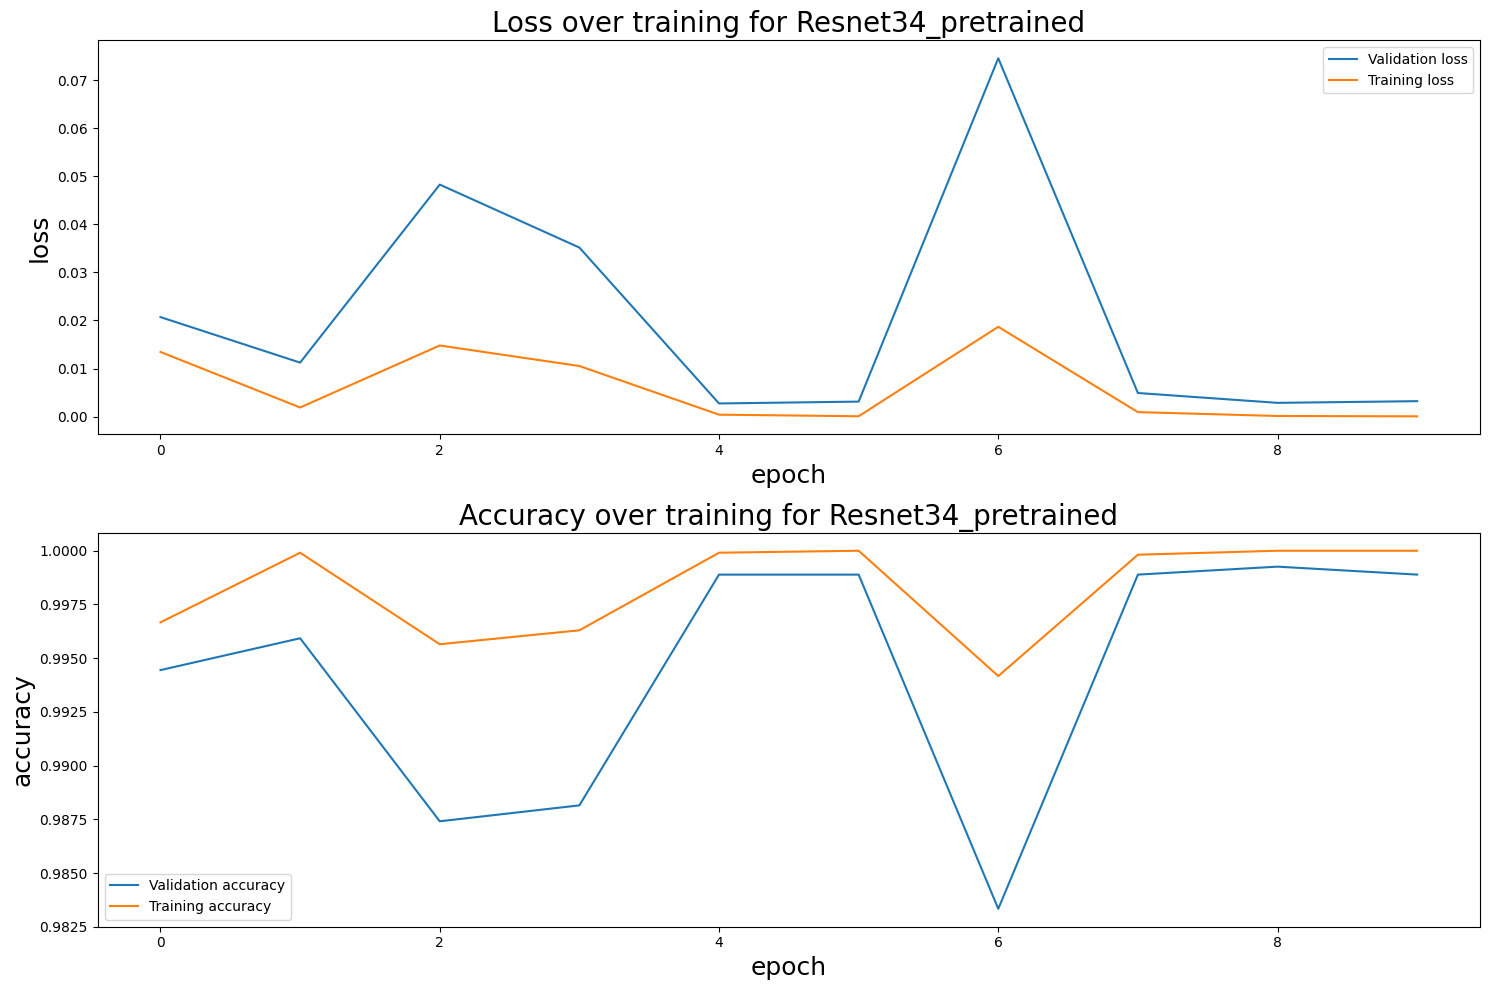

In [6]:
#try more epoches with resnet34
from __future__ import print_function

from utils.params import Params
from utils.plotting import plot_training

import os
import sys
import json
 
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from tqdm import tqdm

import torchvision.models.resnet


torch.cuda.empty_cache()
params = Params("hparams.yaml", 'RESNET_Pretrained')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    "val": transforms.Compose([transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}
if not os.path.exists(params.log_dir): os.makedirs(params.log_dir)
if not os.path.exists(params.checkpoint_dir): os.makedirs(params.checkpoint_dir)
if not os.path.exists("figs"): os.makedirs("figs")
# Dataset root directory
data_dir = './lung_colon_image_set/lung_image_sets'
# Load dataset using ImageFolder
dataset = torchvision.datasets.ImageFolder(root=data_dir,transform=data_transform['val'])
#dataset = [(data.to(device), target.to(device)) for data, target in dataset]
# Set random seed
torch.manual_seed(2024)
# Split dataset into training and testing sets
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
#Split training set into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
train_num = len(train_dataset)
val_num = len(val_dataset)
print("using {} images for training, {} images for validation.".format(train_num,                                                             val_num))


# Load model that has been chosen via the command line arguments.
model_module = __import__('.'.join(['models', params.model_name]),  fromlist=['object'])
net = model_module.net(model_module.BasicBlock, [3, 4, 6, 3], 1000)
# load pretrain weights
# download url: https://download.pytorch.org/models/resnet34-333f7ec4.pth
model_weight_path = "./utils/resnet34-333f7ec4.pth"
assert os.path.exists(model_weight_path), "file {} does not exist.".format(model_weight_path)
net.load_state_dict(torch.load(model_weight_path, map_location='cpu'))
# for param in net.parameters():
#     param.requires_grad = False

# change fc layer structure
in_channel = net.fc.in_features
net.fc = nn.Linear(in_channel, 3)
net.to(device)

# define loss function
loss_function = nn.CrossEntropyLoss()

# construct an optimizer
params = [p for p in net.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=0.0001)

epochs = 20
best_acc = 0.0
save_path = './resNet34.pth'
train_steps = len(train_loader)

import numpy as np
from sklearn.metrics import accuracy_score
import time
# 记录训练开始时间
start_time = time.time()
##train
val_accs = []
val_losses = []
train_losses = []
train_accs = []
def train(model, device, train_loader, optimizer):
    model.train()
    cost = nn.CrossEntropyLoss()
    with tqdm(total=len(train_loader)) as progress_bar:
        for batch_idx, (data, label) in tqdm(enumerate(train_loader)):
            data = data.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = cost(output, label)        
            loss.backward()
            optimizer.step()
            progress_bar.update(1)



def val(model, device, val_loader, checkpoint=None):
    if checkpoint is not None:
        model_state = torch.load(checkpoint)
        model.load_state_dict(model_state)     
    # Need this line for things like dropout etc.  
    model.eval()
    preds = []
    targets = []
    cost = nn.CrossEntropyLoss()
    losses = []
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(val_loader):
            data = data.to(device)
            label = label.to(device)
            target = label.clone()
            output = model(data)
            preds.append(output.cpu().numpy())
            targets.append(target.cpu().numpy())
            losses.append(cost(output, label).cpu().numpy())
    loss = np.mean(losses)
    preds = np.argmax(np.concatenate(preds), axis=1)
    targets  = np.concatenate(targets)
    acc = accuracy_score(targets, preds)
    return loss, acc
#with torch.no_grad():
for epoch in range(1, 11):
    torch.cuda.empty_cache()
    print("Epoch: {}".format(epoch))
    # Call training function.
    train(net, device, train_loader, optimizer)
    # Evaluate on both the training and validation set.
    train_loss, train_acc = val(net, device, train_loader)
    val_loss, val_acc = val(net, device, val_loader)
    # Collect some data for logging purposes.
    train_losses.append(float(train_loss))
    train_accs.append(train_acc)
    val_losses.append(float(val_loss))
    val_accs.append(val_acc)

    print('\n\ttrain Loss: {:.6f}\ttrain acc: {:.6f} \n\tval Loss: {:.6f}\tval acc: {:.6f}'.format(train_loss, train_acc, val_loss, val_acc))

    # Save model every few epochs (or even more often if you have the disk space).
    if epoch % 5 == 0:
        torch.save(net.state_dict(), os.path.join("checkpoints/resnet-pretrained","checkpoint_{}_epoch_{}".format("resnet34-pretrained-HistoImage",epoch)))
# 计算总的训练时间并打印
total_time = time.time() - start_time
print("Total training time: {:.2f} seconds.".format(total_time))
# Clear plot each epoch
fig = plot_training(train_losses, train_accs,val_losses, val_accs,'Resnet34_pretrained')
fig.savefig(os.path.join("figs", "{}_training_vis".format("Resnet34_pretrained-HistoImage")))
# Some log information to help you keep track of your model information.
logs ={
    "model": "Resnet_pretrained",
    #"model": args.model_name,
    "train_losses": train_losses,
    "train_accs": train_accs,
    "val_losses": val_losses,
    "val_accs": val_accs,
    "best_val_epoch": int(np.argmax(val_accs)+1),
    #"model": args.model_name,
    "model": "Resnet_pretrained",
    "lr": 0.0001,
    "batch_size":32
}
start_time = time.strftime("%d%m%y_%H%M%S")
with open(os.path.join('logs/resnet-pretrained',"{}_{}.json".format("Resnet34_pretrained-HistoImage",  start_time)), 'w') as f:
    json.dump(logs, f)



# Resnet18 pretrained


using cuda:0 device.
using 10800 images for training, 2700 images for validation.
Epoch: 1


100%|██████████| 338/338 [01:37<00:00,  4.00it/s]
338it [01:37,  3.47it/s]
100%|██████████| 338/338 [01:37<00:00,  3.47it/s]



	train Loss: 0.018839	train acc: 0.993241 
	val Loss: 0.029720	val acc: 0.988889
Epoch: 2


100%|██████████| 338/338 [01:40<00:00,  4.03it/s]
338it [01:40,  3.36it/s]
100%|██████████| 338/338 [01:40<00:00,  3.36it/s]



	train Loss: 0.012798	train acc: 0.996019 
	val Loss: 0.032571	val acc: 0.989630
Epoch: 3


100%|██████████| 338/338 [01:40<00:00,  3.72it/s]
338it [01:40,  3.35it/s]
100%|██████████| 338/338 [01:40<00:00,  3.35it/s]



	train Loss: 0.000499	train acc: 1.000000 
	val Loss: 0.005373	val acc: 0.998519
Epoch: 4


100%|██████████| 338/338 [01:40<00:00,  3.76it/s]
338it [01:40,  3.36it/s]
100%|██████████| 338/338 [01:40<00:00,  3.36it/s]



	train Loss: 0.011976	train acc: 0.995926 
	val Loss: 0.024007	val acc: 0.990741
Epoch: 5


100%|██████████| 338/338 [01:41<00:00,  4.09it/s]
338it [01:41,  3.33it/s]
100%|██████████| 338/338 [01:41<00:00,  3.33it/s]



	train Loss: 0.001778	train acc: 0.999537 
	val Loss: 0.006229	val acc: 0.998148
Epoch: 6


100%|██████████| 338/338 [01:40<00:00,  3.87it/s]
338it [01:40,  3.35it/s]
100%|██████████| 338/338 [01:40<00:00,  3.35it/s]



	train Loss: 0.005217	train acc: 0.998611 
	val Loss: 0.020523	val acc: 0.995185
Epoch: 7


100%|██████████| 338/338 [01:40<00:00,  3.92it/s]
338it [01:40,  3.35it/s]
100%|██████████| 338/338 [01:40<00:00,  3.35it/s]



	train Loss: 0.004270	train acc: 0.998981 
	val Loss: 0.032151	val acc: 0.994074
Epoch: 8


100%|██████████| 338/338 [01:41<00:00,  3.94it/s]
338it [01:41,  3.33it/s]
100%|██████████| 338/338 [01:41<00:00,  3.33it/s]



	train Loss: 0.002741	train acc: 0.999815 
	val Loss: 0.017006	val acc: 0.995185
Epoch: 9


100%|██████████| 338/338 [01:40<00:00,  3.90it/s]
338it [01:40,  3.35it/s]
100%|██████████| 338/338 [01:40<00:00,  3.35it/s]



	train Loss: 0.001949	train acc: 0.999722 
	val Loss: 0.007696	val acc: 0.997407
Epoch: 10


100%|██████████| 338/338 [01:41<00:00,  3.98it/s]
338it [01:41,  3.34it/s]
100%|██████████| 338/338 [01:41<00:00,  3.34it/s]



	train Loss: 0.002390	train acc: 0.999630 
	val Loss: 0.006362	val acc: 0.998519
Total training time: 2429.45 seconds.


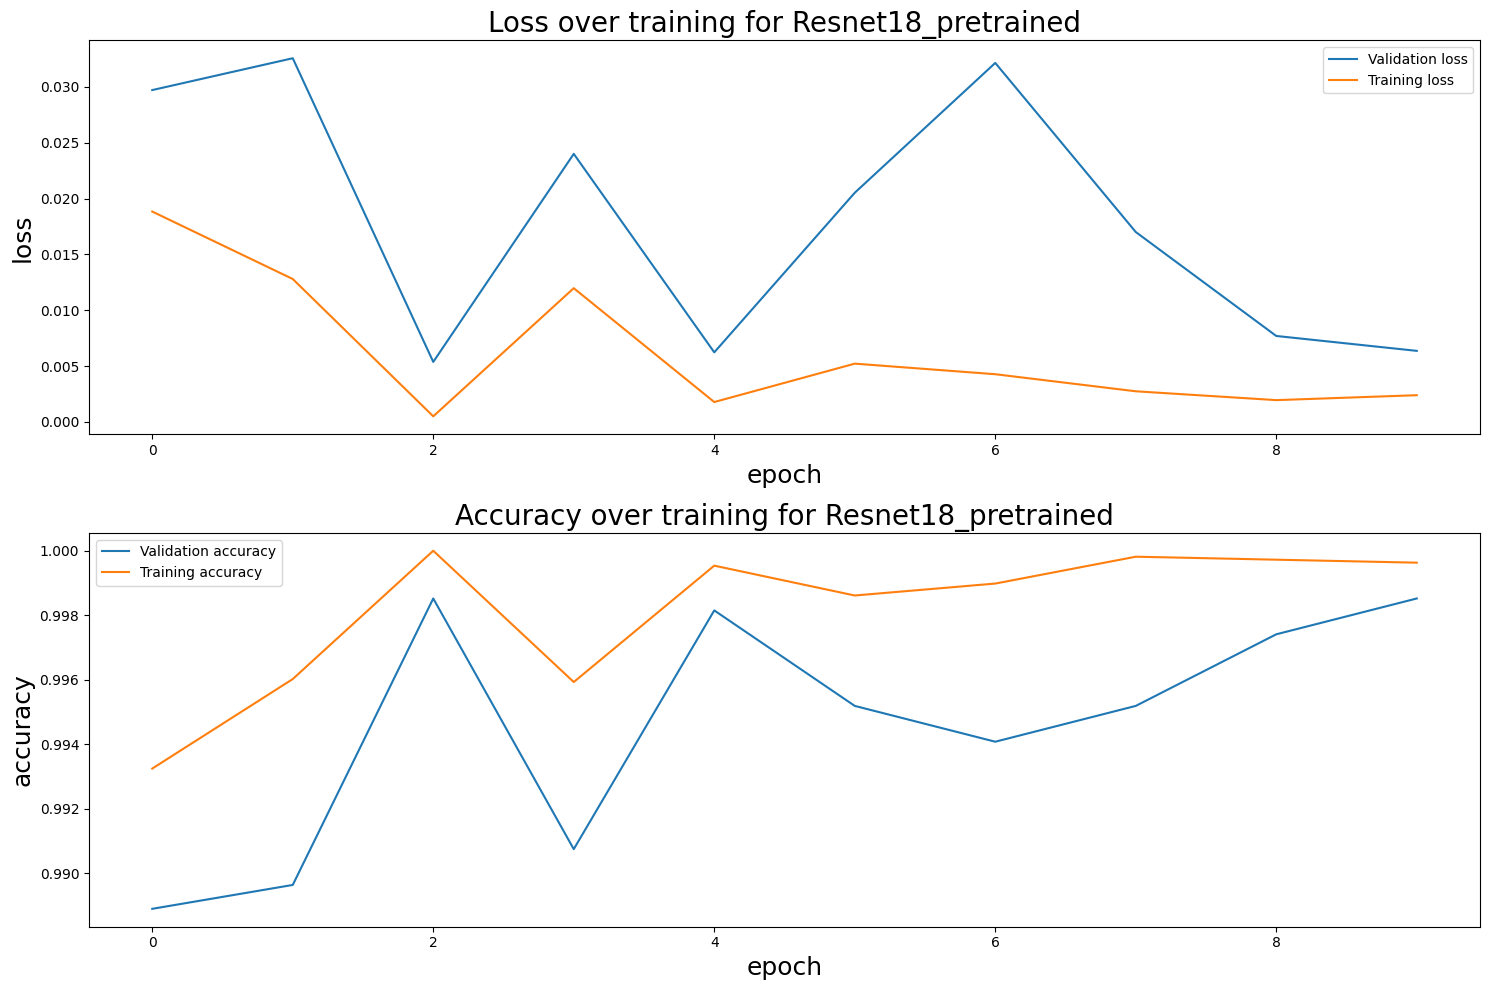

In [8]:
from __future__ import print_function

from utils.params import Params
from utils.plotting import plot_training

import os
import sys
import json
 
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from tqdm import tqdm

import torchvision.models.resnet


torch.cuda.empty_cache()
params = Params("hparams.yaml", 'RESNET_Pretrained')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    "val": transforms.Compose([transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}
if not os.path.exists(params.log_dir): os.makedirs(params.log_dir)
if not os.path.exists(params.checkpoint_dir): os.makedirs(params.checkpoint_dir)
if not os.path.exists("figs"): os.makedirs("figs")
# Dataset root directory
data_dir = './lung_colon_image_set/lung_image_sets'
# Load dataset using ImageFolder
dataset = torchvision.datasets.ImageFolder(root=data_dir,transform=data_transform['val'])
#dataset = [(data.to(device), target.to(device)) for data, target in dataset]
# Set random seed
torch.manual_seed(2024)
# Split dataset into training and testing sets
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
#Split training set into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])


train_num = len(train_dataset)
# Create data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_num = len(val_dataset)
print("using {} images for training, {} images for validation.".format(train_num,
                                                                       val_num))


# Load model that has been chosen via the command line arguments.
model_module = __import__('.'.join(['models', params.model_name]),  fromlist=['object'])
net = model_module.net(model_module.BasicBlock, [2,2,2,2], 1000)
# load pretrain weights
# download url: https://download.pytorch.org/models/resnet34-333f7ec4.pth
model_weight_path = "./utils/resnet18-f37072fd.pth"
assert os.path.exists(model_weight_path), "file {} does not exist.".format(model_weight_path)
net.load_state_dict(torch.load(model_weight_path, map_location='cpu'))
# for param in net.parameters():
#     param.requires_grad = False

# change fc layer structure
in_channel = net.fc.in_features
net.fc = nn.Linear(in_channel, 10)
net.to(device)

# define loss function
loss_function = nn.CrossEntropyLoss()

# construct an optimizer
params = [p for p in net.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=0.0001)
import numpy as np
from sklearn.metrics import accuracy_score
import time
##train
start_time = time.time()

val_accs = []
val_losses = []
train_losses = []
train_accs = []
def train(model, device, train_loader, optimizer):
    model.train()
    cost = nn.CrossEntropyLoss()
    with tqdm(total=len(train_loader)) as progress_bar:
        for batch_idx, (data, label) in tqdm(enumerate(train_loader)):
            data = data.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = cost(output, label)        
            loss.backward()
            optimizer.step()
            progress_bar.update(1)



def val(model, device, val_loader, checkpoint=None):
    if checkpoint is not None:
        model_state = torch.load(checkpoint)
        model.load_state_dict(model_state)     
    # Need this line for things like dropout etc.  
    model.eval()
    preds = []
    targets = []
    cost = nn.CrossEntropyLoss()
    losses = []
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(val_loader):
            data = data.to(device)
            label = label.to(device)
            target = label.clone()
            output = model(data)
            preds.append(output.cpu().numpy())
            targets.append(target.cpu().numpy())
            losses.append(cost(output, label).cpu().numpy())
    loss = np.mean(losses)
    preds = np.argmax(np.concatenate(preds), axis=1)
    targets  = np.concatenate(targets)
    acc = accuracy_score(targets, preds)
    return loss, acc
#with torch.no_grad():
for epoch in range(1, 11):
    torch.cuda.empty_cache()
    print("Epoch: {}".format(epoch))
    # Call training function.
    train(net, device, train_loader, optimizer)
    # Evaluate on both the training and validation set.
    train_loss, train_acc = val(net, device, train_loader)
    val_loss, val_acc = val(net, device, val_loader)
    # Collect some data for logging purposes.
    train_losses.append(float(train_loss))
    train_accs.append(train_acc)
    val_losses.append(float(val_loss))
    val_accs.append(val_acc)

    print('\n\ttrain Loss: {:.6f}\ttrain acc: {:.6f} \n\tval Loss: {:.6f}\tval acc: {:.6f}'.format(train_loss, train_acc, val_loss, val_acc))

    # Save model every few epochs (or even more often if you have the disk space).
    if epoch % 5 == 0:
        torch.save(net.state_dict(), os.path.join("checkpoints/resnet-pretrained","checkpoint_{}_epoch_{}".format("resnet18-pretrained",epoch)))
# 计算总的训练时间并打印
total_time = time.time() - start_time
print("Total training time: {:.2f} seconds.".format(total_time))
# Clear plot each epoch
fig = plot_training(train_losses, train_accs,val_losses, val_accs,'Resnet18_pretrained')
fig.savefig(os.path.join("figs", "{}_training_vis".format("Resnet18_pretrained")))
# Some log information to help you keep track of your model information.
logs ={
    "model": "Resnet_pretrained",
    #"model": args.model_name,
    "train_losses": train_losses,
    "train_accs": train_accs,
    "val_losses": val_losses,
    "val_accs": val_accs,
    "best_val_epoch": int(np.argmax(val_accs)+1),
    #"model": args.model_name,
    "model": "Resnet_pretrained",
    "lr": 0.0001,
    "batch_size":32
}
start_time = time.strftime("%d%m%y_%H%M%S")
with open(os.path.join('logs/resnet-pretrained',"{}_{}.json".format("Resnet18_pretrained",  start_time)), 'w') as f:
    json.dump(logs, f)


# Use resnet 50 for histopathological images

In [8]:
#! python main.py CNN
from __future__ import print_function
import os
import time
import json
import argparse


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import models
from utils import Datasets
from utils.params import Params
from utils.plotting import plot_training
def main(modelName, batchSize):
    '''
    modelName: 'CNN', 'RESNET50',in hparams.yaml
    batchSize: loader size
    '''
    start_time = time.strftime("%d%m%y_%H%M%S")
    
    torch.cuda.empty_cache()
    params = Params("hparams.yaml", modelName)
    #os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
    #os.environ["CUDA_VISIBLE_DEVICES"]=params.gpu_vis_dev    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    
    # Load model that has been chosen via the command line arguments.
    model_module = __import__('.'.join(['models', params.model_name]),  fromlist=['object'])
    
    model = model_module.net(model_module.Bottleneck, [3, 4, 6, 3], 10)


    # Send the model to the chosen device.
    # To use multiple GPUs
    #model = nn.DataParallel(model)
    model = model.to(device)
    #print('train X device:', model.device)
    
    #Grap your training and validation functions for your network.
    train = model_module.train
    val = model_module.val
    
    
    optimizer = optim.Adam(model.parameters(), lr=params.lr)
    
    if not os.path.exists(params.log_dir): os.makedirs(params.log_dir)
    if not os.path.exists(params.checkpoint_dir): os.makedirs(params.checkpoint_dir)
    if not os.path.exists("figs"): os.makedirs("figs")
    
    if params.model_name=='resnet50' or params.model_name=='resnet50_hist' :
        transform = transforms.Compose([
        transforms.Resize((256, 256)),  # 调整图像大小
        transforms.CenterCrop(224),  # 中心裁剪
        transforms.ToTensor(),  # 转换为张量
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
    ])
    # Dataset root directory
    data_dir = './lung_colon_image_set/lung_image_sets'
    # Load dataset using ImageFolder
    dataset = torchvision.datasets.ImageFolder(root=data_dir,transform=transform)
    
    # Set random seed
    torch.manual_seed(2024)
    # Split dataset into training and testing sets
    train_size = int(0.9 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    #Split training set into training and validation sets
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
    


    # Create data loaders
    batch_size = batchSize
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    
    
    ##train
    val_accs = []
    val_losses = []
    train_losses = []
    train_accs = []
    #with torch.no_grad():
    for epoch in range(1, params.num_epochs + 1):
        torch.cuda.empty_cache()
        print("Epoch: {}".format(epoch))
        # Call training function.
        train(model, device, train_loader, optimizer)
        # Evaluate on both the training and validation set.
        train_loss, train_acc = val(model, device, train_loader)
        val_loss, val_acc = val(model, device, val_loader)
        # Collect some data for logging purposes.
        train_losses.append(float(train_loss))
        train_accs.append(train_acc)
        val_losses.append(float(val_loss))
        val_accs.append(val_acc)
    
        print('\n\ttrain Loss: {:.6f}\ttrain acc: {:.6f} \n\tval Loss: {:.6f}\tval acc: {:.6f}'.format(train_loss, train_acc, val_loss, val_acc))
    
        # Save model every few epochs (or even more often if you have the disk space).
        if epoch % 5 == 0:
            torch.save(model.state_dict(), os.path.join(params.checkpoint_dir,"checkpoint_{}_epoch_{}".format(modelName,epoch)))
    # Clear plot each epoch
    fig = plot_training(train_losses, train_accs,val_losses, val_accs,modelName)
    fig.savefig(os.path.join("figs", "{}Histoimage_training_vis".format(modelName)))
    # Some log information to help you keep track of your model information.
    logs ={
        "model": modelName,
        #"model": args.model_name,
        "train_losses": train_losses,
        "train_accs": train_accs,
        "val_losses": val_losses,
        "val_accs": val_accs,
        "best_val_epoch": int(np.argmax(val_accs)+1),
        #"model": args.model_name,
        "model": modelName,
        "lr": params.lr,
        "batch_size":params.batch_size
    }
    
    with open(os.path.join(params.log_dir,"{}_{}.json".format(modelName,  start_time)), 'w') as f:
        json.dump(logs, f)



cuda:0
Epoch: 1


100%|██████████| 169/169 [01:56<00:00,  1.49it/s]
169it [01:56,  1.46it/s]
100%|██████████| 169/169 [01:56<00:00,  1.46it/s]



	train Loss: 0.112714	train acc: 0.953704 
	val Loss: 0.137703	val acc: 0.945185
Epoch: 2


100%|██████████| 169/169 [01:52<00:00,  1.59it/s]
169it [01:52,  1.50it/s]
100%|██████████| 169/169 [01:52<00:00,  1.50it/s]



	train Loss: 0.125698	train acc: 0.945648 
	val Loss: 0.161896	val acc: 0.924815
Epoch: 3


100%|██████████| 169/169 [01:47<00:00,  1.71it/s]
169it [01:47,  1.58it/s]
100%|██████████| 169/169 [01:47<00:00,  1.58it/s]



	train Loss: 0.055524	train acc: 0.980185 
	val Loss: 0.106901	val acc: 0.958519
Epoch: 4


100%|██████████| 169/169 [01:46<00:00,  1.73it/s]
169it [01:46,  1.59it/s]
100%|██████████| 169/169 [01:46<00:00,  1.59it/s]



	train Loss: 0.026803	train acc: 0.991667 
	val Loss: 0.068202	val acc: 0.975185
Epoch: 5


100%|██████████| 169/169 [01:47<00:00,  1.61it/s]
169it [01:47,  1.58it/s]
100%|██████████| 169/169 [01:47<00:00,  1.58it/s]



	train Loss: 0.026534	train acc: 0.990556 
	val Loss: 0.084946	val acc: 0.965185
Epoch: 6


100%|██████████| 169/169 [01:48<00:00,  1.72it/s]
169it [01:48,  1.56it/s]
100%|██████████| 169/169 [01:48<00:00,  1.56it/s]



	train Loss: 0.014564	train acc: 0.996019 
	val Loss: 0.074751	val acc: 0.971852
Epoch: 7


100%|██████████| 169/169 [01:48<00:00,  1.67it/s]
169it [01:48,  1.55it/s]
100%|██████████| 169/169 [01:48<00:00,  1.55it/s]



	train Loss: 0.013412	train acc: 0.996481 
	val Loss: 0.071806	val acc: 0.974444
Epoch: 8


100%|██████████| 169/169 [01:47<00:00,  1.70it/s]
169it [01:47,  1.57it/s]
100%|██████████| 169/169 [01:47<00:00,  1.57it/s]



	train Loss: 0.023076	train acc: 0.992315 
	val Loss: 0.109913	val acc: 0.967407
Epoch: 9


100%|██████████| 169/169 [01:48<00:00,  1.82it/s]
169it [01:48,  1.56it/s]
100%|██████████| 169/169 [01:48<00:00,  1.56it/s]



	train Loss: 0.013713	train acc: 0.996019 
	val Loss: 0.090523	val acc: 0.972593
Epoch: 10


100%|██████████| 169/169 [01:48<00:00,  1.67it/s]
169it [01:48,  1.55it/s]
100%|██████████| 169/169 [01:48<00:00,  1.55it/s]



	train Loss: 0.009092	train acc: 0.997963 
	val Loss: 0.059441	val acc: 0.976667


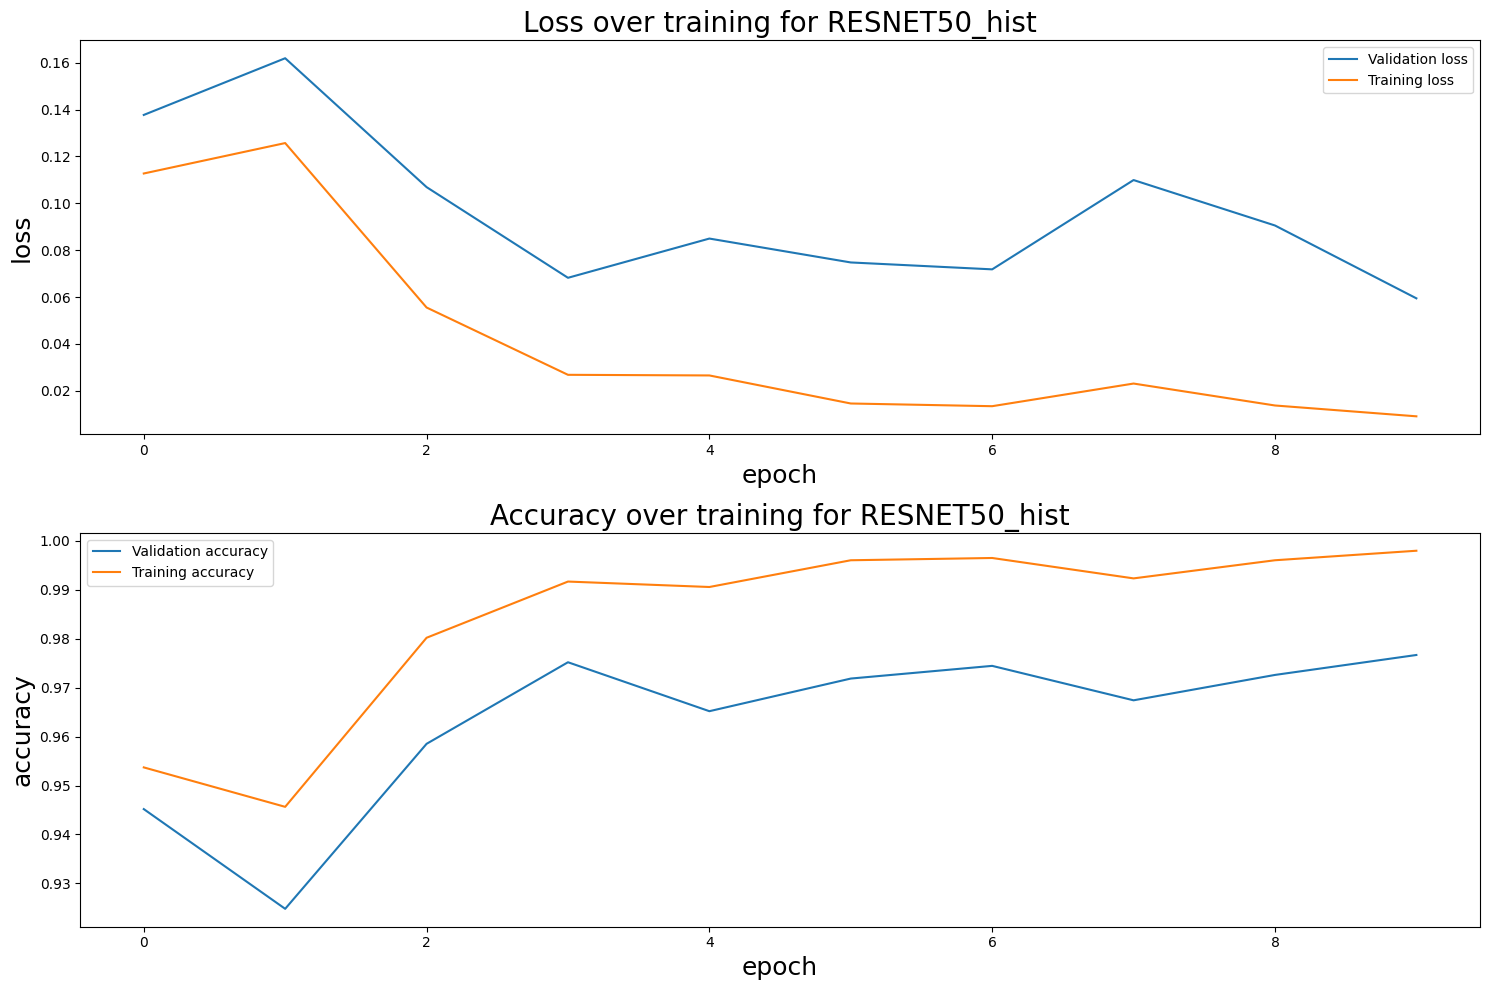

In [9]:
main("RESNET50_hist",64)